#### Vehicle tracking with LIDAR Point Cloud Measurement using Unscented Kalman Filter (UKF)

In [1]:
# Import Python and Numpy/Scipy libaries/packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
from glob import glob
from math import log, exp, sqrt, fabs, sin, cos, atan2, tan
from numpy import eye, zeros, dot, isscalar, outer
from numpy.random import randn
from numpy.linalg import norm
import scipy.stats as stats
# Import Point Cloud Library
import pcl
# Import pcl_processing functions
from pcl_processing import *
# Import UKF class
from ukf import *

# Import process and measurement model
from process_measurement import ctrv, lidar

The key parameters for LIDAR point cloud processing. 

In [2]:
parameters ={'leaf_sizes': [0.1, 0.1, 0.1], 
             'x_roi': [-100, 100], 
             'y_roi': [-6, 6], 
             'z_roi': [0, 3],
              'dist_thold': 0.1,
             'max_iter': 100,
             'tol': 1.5, 
             'min_size': 30,
              'max_size': 2500}

The function that implements the LIDAR point cloud processing pipeline

In [3]:
def lidar_pcl(cloud_XYZ, parameters):
    '''
    Input:
      cloud_XYZ: point cloud
      parameters: processing parameters
    Ouput:
      cloud_obsts: points associated with obstacles
      box_coord_list: the coordinates of all the bounding boxes 
      obst_centroid_list: centroids of all the bounding boxes as position measurements
    
    '''
    # Upack the parameters 
    leaf_sizes = parameters['leaf_sizes']
    x_roi = parameters['x_roi']
    y_roi = parameters['y_roi']
    z_roi = parameters['z_roi']
    dist_thold = parameters['dist_thold']
    max_iter = parameters['max_iter']
    tol = parameters['tol']
    min_size = parameters['min_size']
    max_size = parameters['max_size']
    
    # Down-sampling
    cloud_voxel_filtered = voxel_filter(cloud_XYZ, leaf_sizes)
    cloud_roi_filtered = roi_filter(cloud_voxel_filtered, x_roi, y_roi, z_roi)
    
    # Plane segmentation
    indices, coefficients = plane_segmentation(cloud_roi_filtered, 0.01, 100)
    # Exact points that are associated with obstacles
    cloud_obsts = cloud_roi_filtered.extract(indices, negative = True)
    # Clustering
    cluster_indices = clustering(cloud_obsts, tol, min_size, max_size)
    cloud_cluster_list, box_coord_list = get_cluster_box_list(cluster_indices, cloud_obsts)
    obst_centroid_list = []

    # Use the centroid of the bounding box as the position measurements
    for box in box_coord_list:
        x_c, y_c, z_c = box_center(box)
        obst_centroid_list.append([x_c, y_c, z_c])
        
    return np.array(cloud_obsts), box_coord_list, obst_centroid_list    
    

In [4]:
def closest_measurement(x, z_list):
    '''
    Simple function that finds the closest measurement to the current estimate
    Input:
        x: current estimate
        z_list: the list of available measurements
    
    Output:
        z_nearest: the measurement that is closes to x in z_list
    '''
        
    z_list = np.asarray(z_list)
    dist_2 = np.sum((z_list - x)**2, axis=1)
    z_nearest = z_list[np.argmin(dist_2)]
    return z_nearest

In [7]:
def tracking_visualization(cloud_obsts, box_coor_list, axes_str, axes_limits):
    '''
    Visualization of the tracking
    Input: 
        cloud_obsts: points associated with obstacles
        box_coord_list: the coordinates of all the bounding boxes 
        obst_centroid_list: centroids of all the bounding boxes as position measurements
    Output:
        None
    '''
    f = plt.figure(figsize=(6, 4))
    ax = f.add_subplot(111) 
    draw_point_cloud(cloud_obsts, ax, 'XY projection (Z = 0)', axes=[0, 1], axes_str = axes_str, axes_limits = axes_limits)
    for box in box_coord_list:
        x_c, y_c, z_c = box_center(box)
        draw_box(ax, box, axes=[0, 1], color='m')
        plt.xlim([-50, 50])
        plt.ylim([-6, 6])
        plt.axis('equal')

    est_np = np.array(estimate)
    x_e_cur = est_np[:,0]
    y_e_cur = est_np[:,1]

    plt.plot(x_e_cur, y_e_cur, 'r')
    plt.xlim([-50, 50])
    plt.ylim([-6, 6])
    plt.axis('equal')
    plt.pause(0.002)
    plt.show()

Implement and visualize tracking with UKF

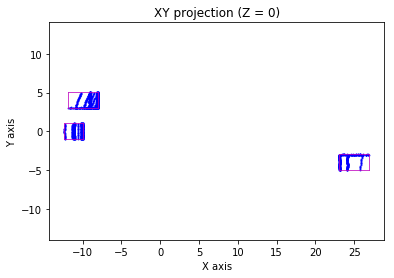

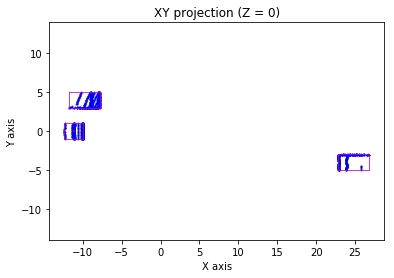

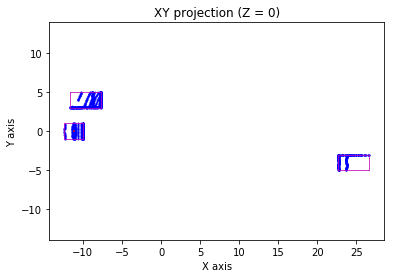

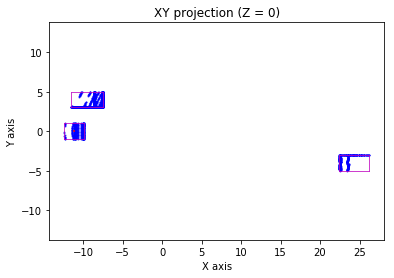

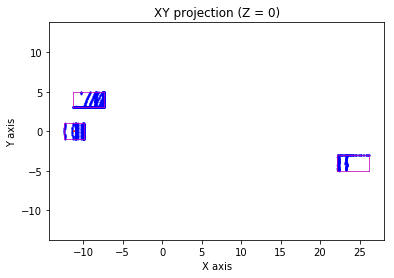

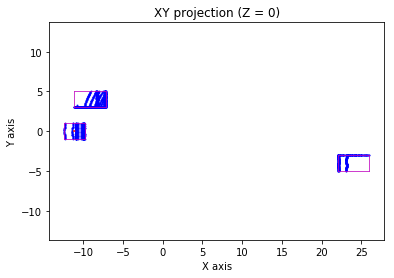

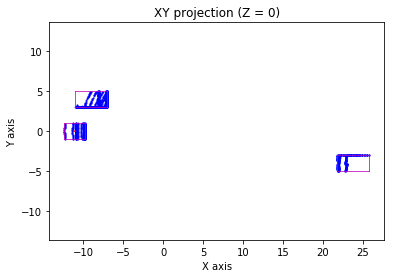

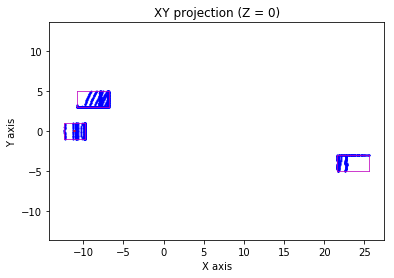

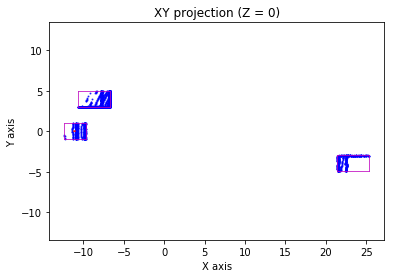

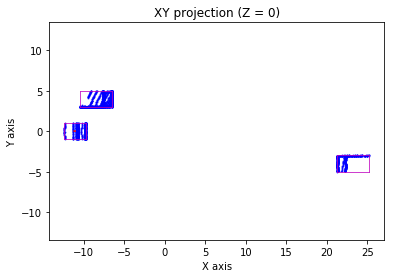

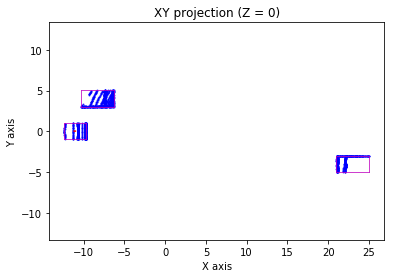

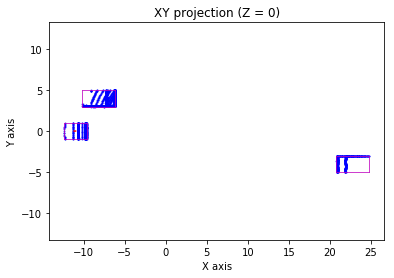

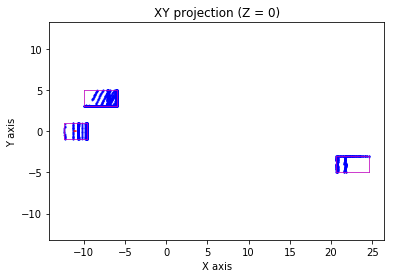

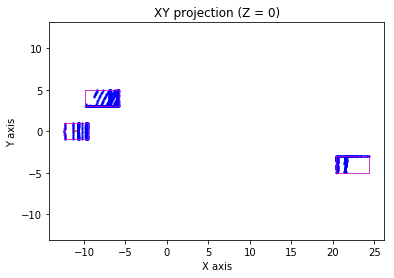

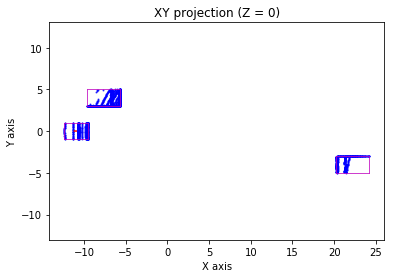

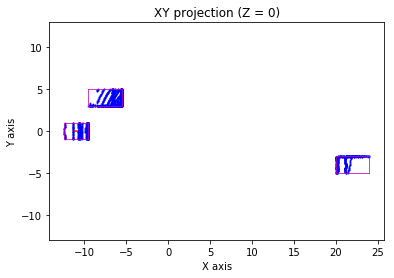

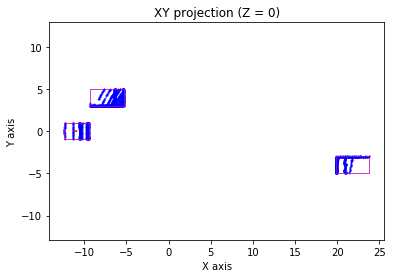

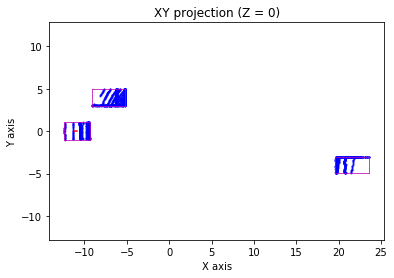

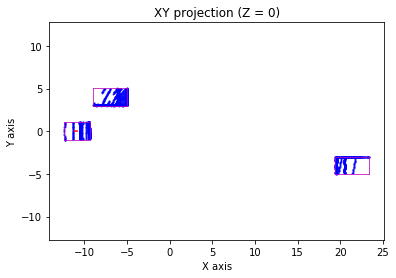

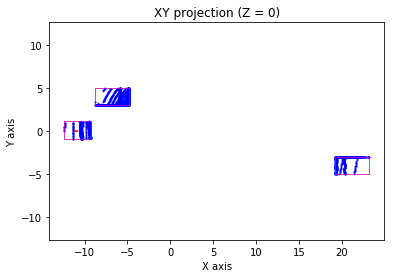

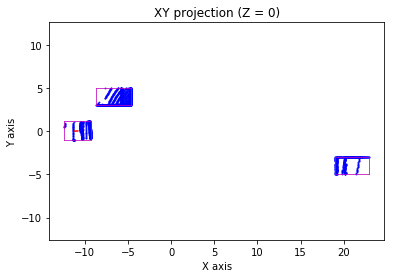

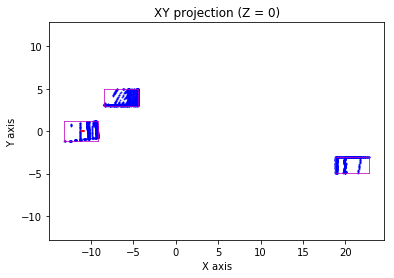

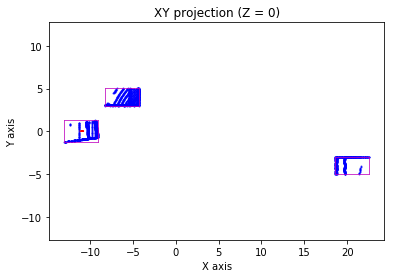

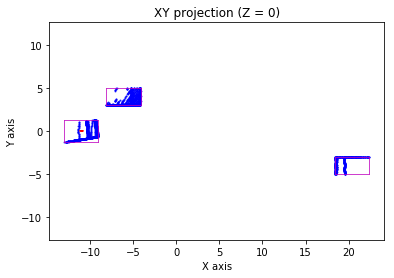

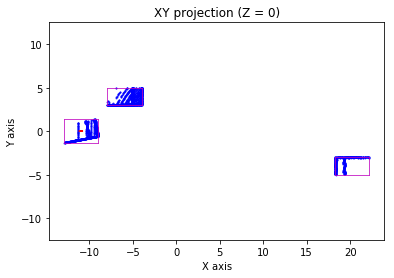

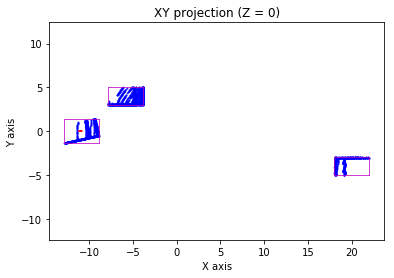

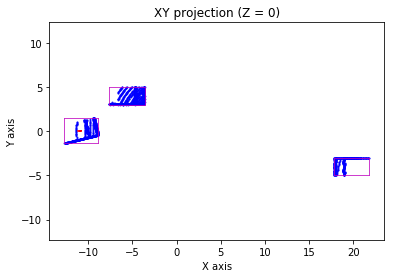

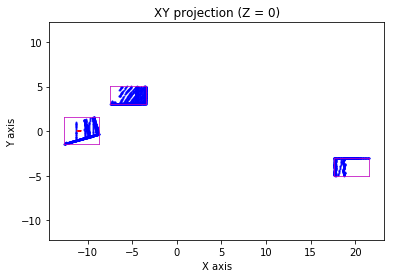

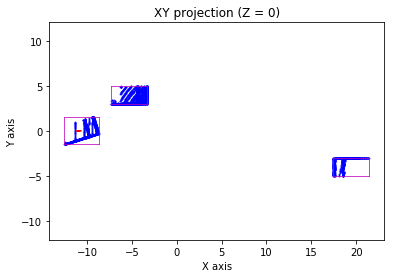

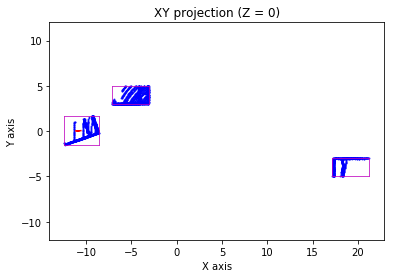

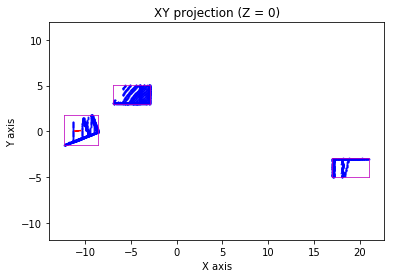

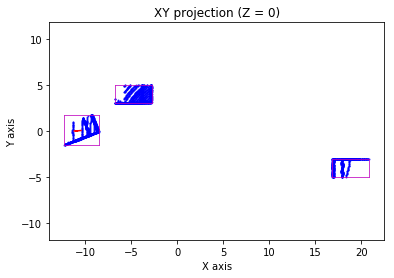

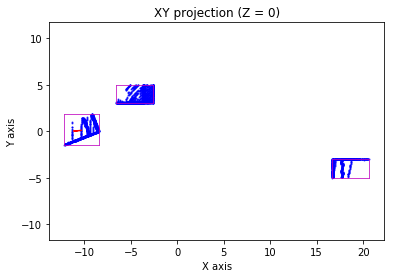

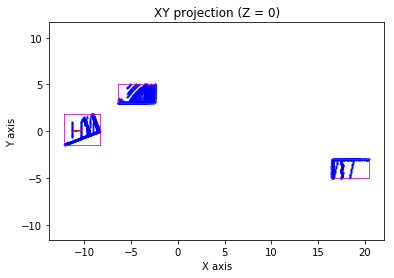

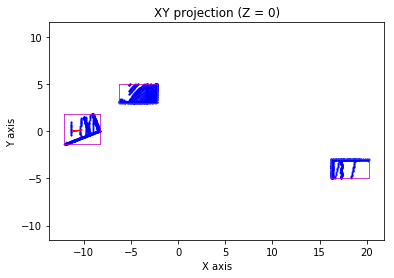

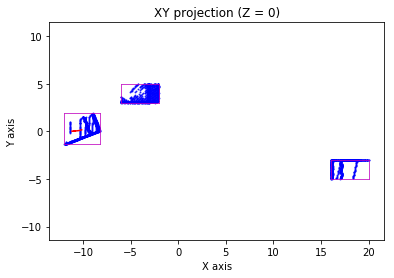

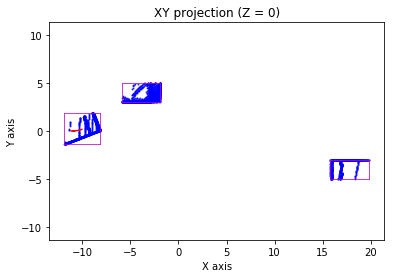

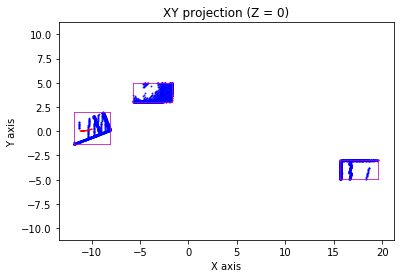

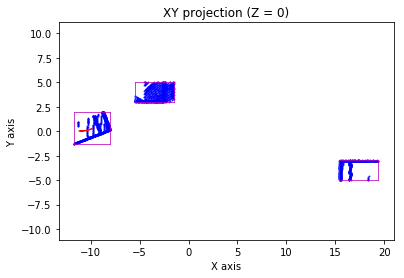

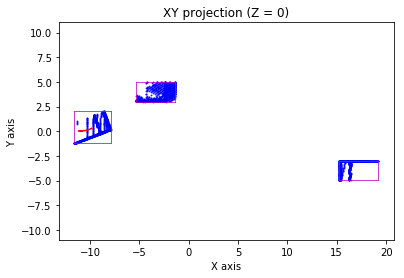

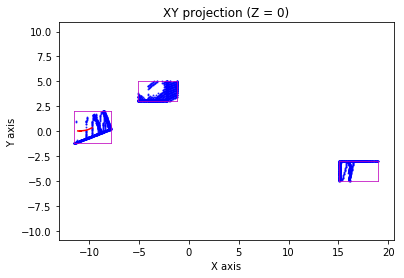

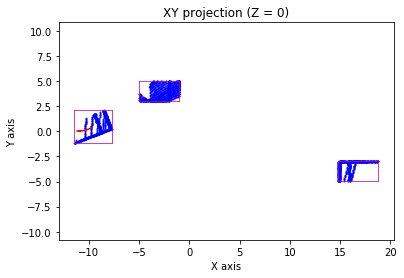

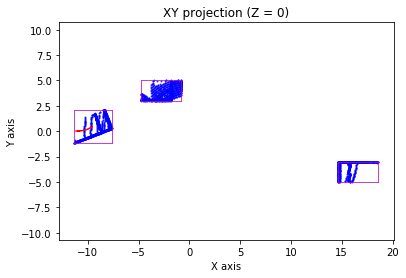

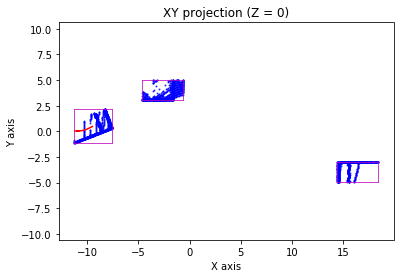

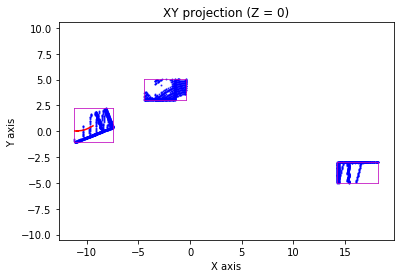

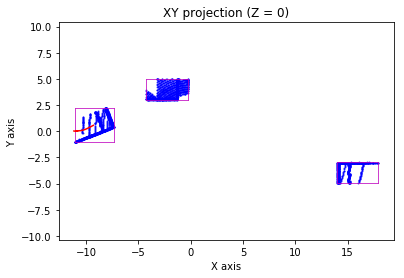

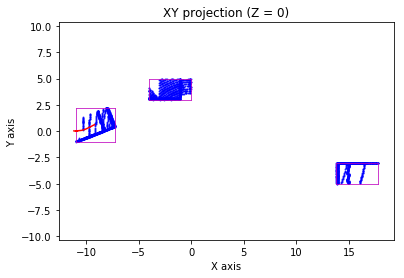

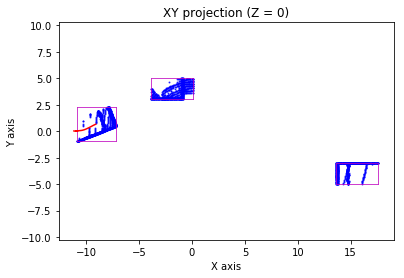

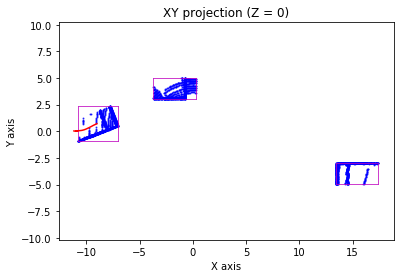

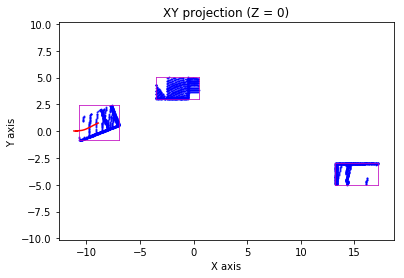

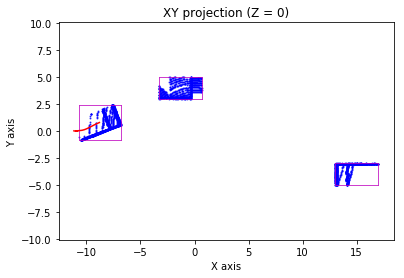

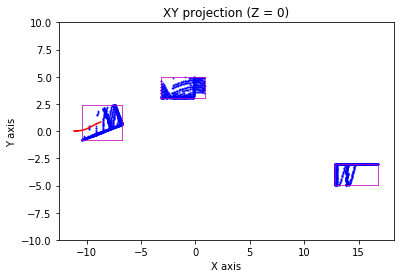

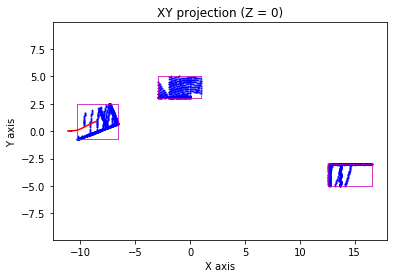

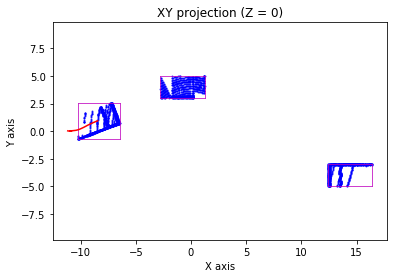

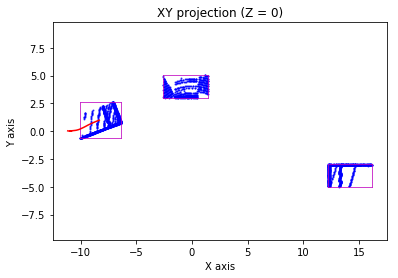

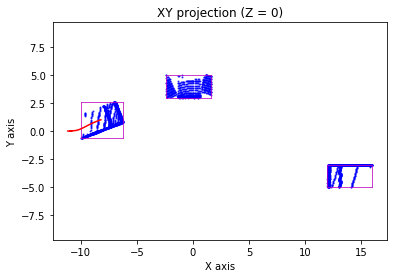

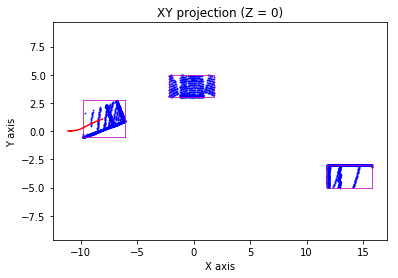

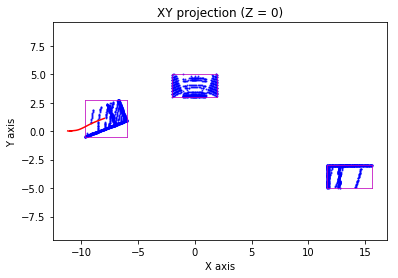

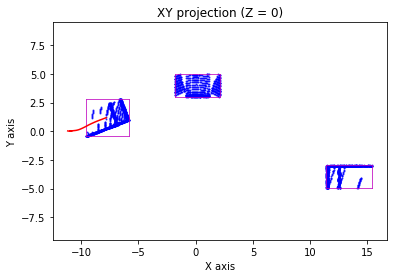

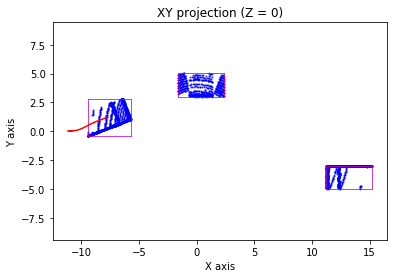

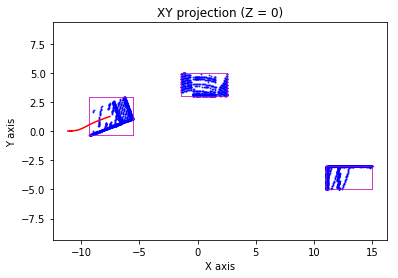

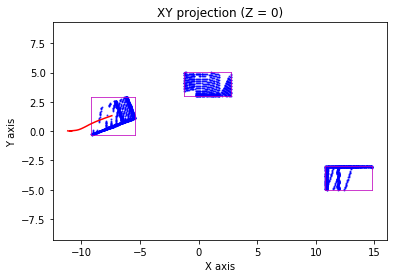

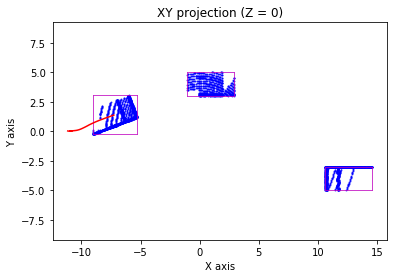

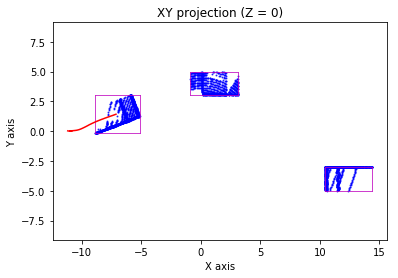

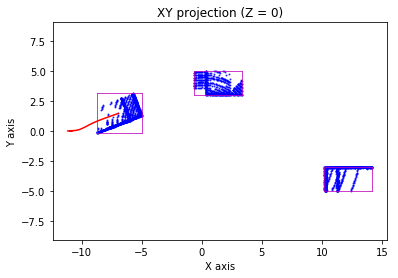

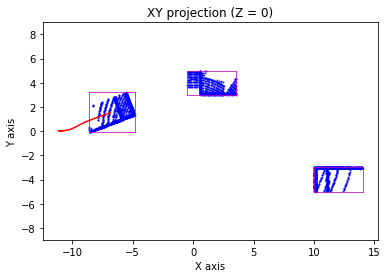

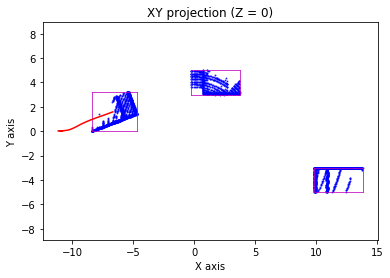

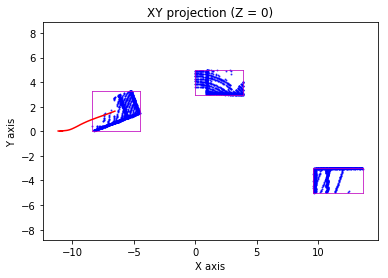

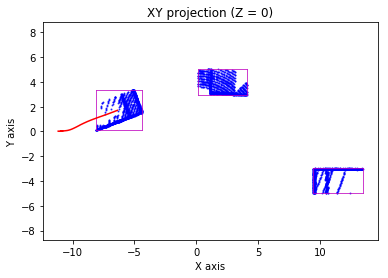

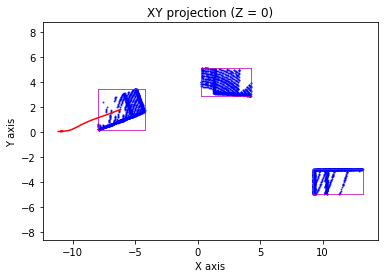

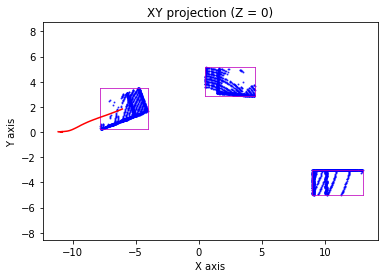

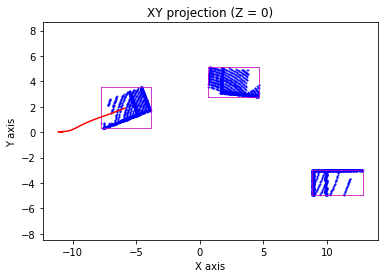

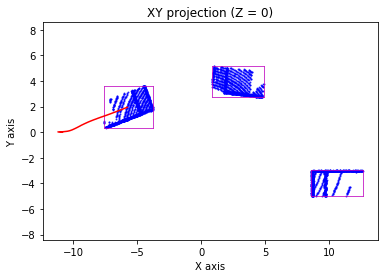

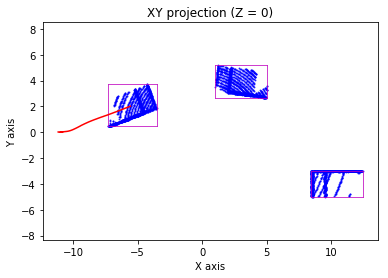

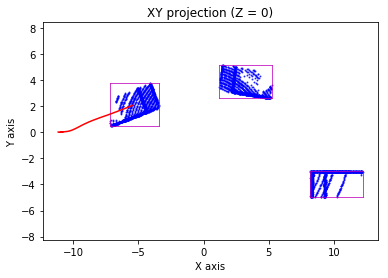

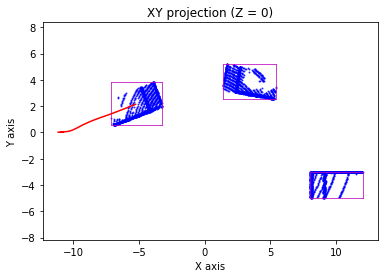

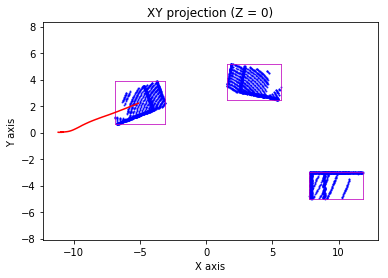

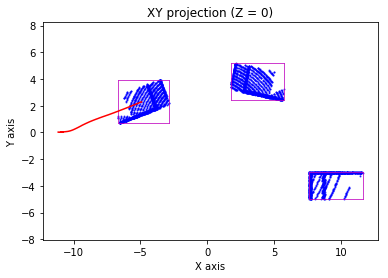

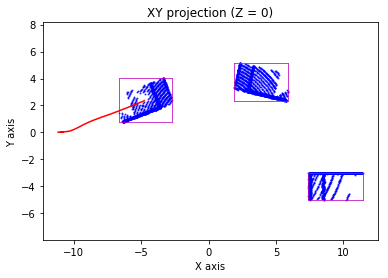

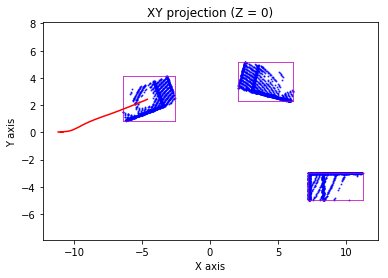

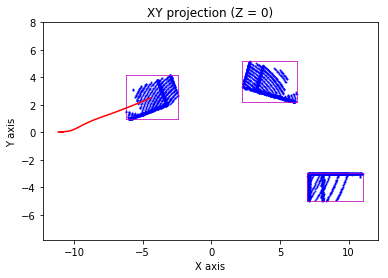

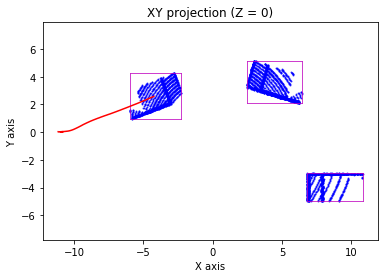

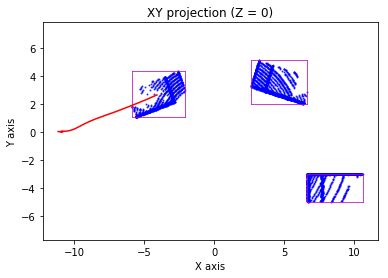

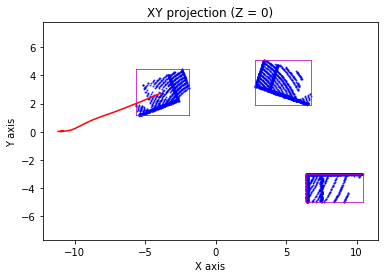

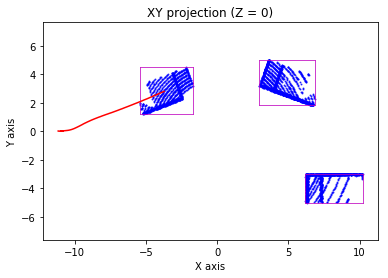

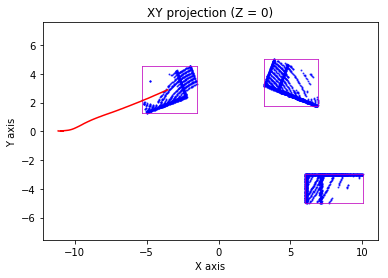

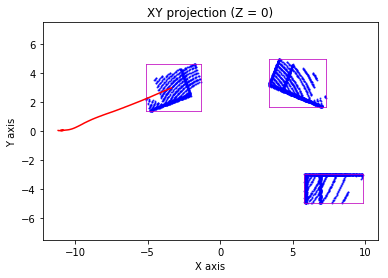

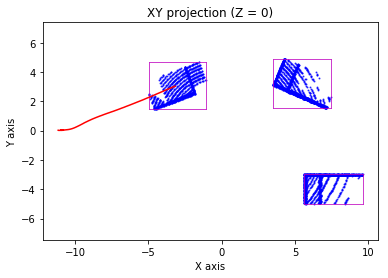

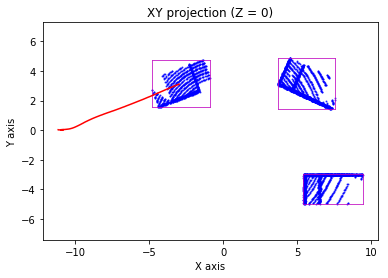

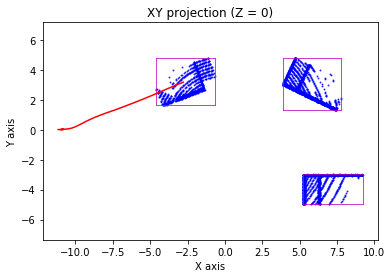

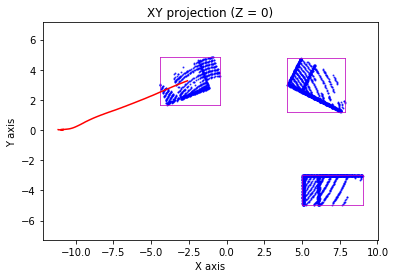

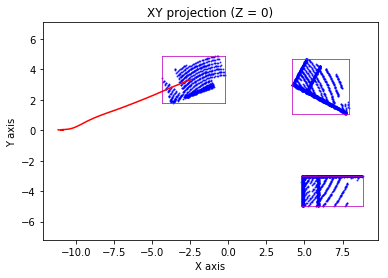

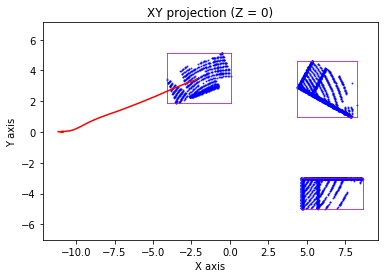

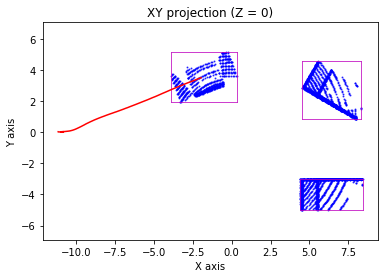

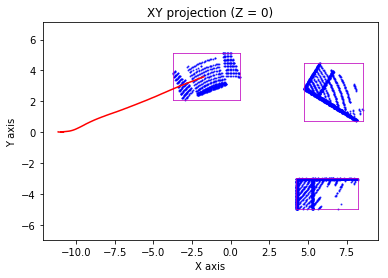

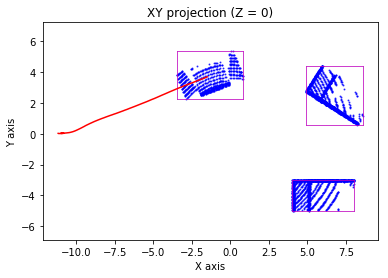

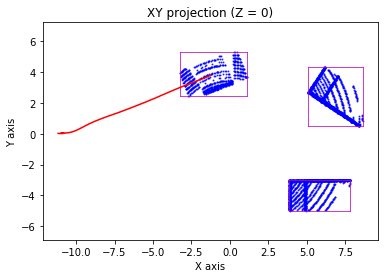

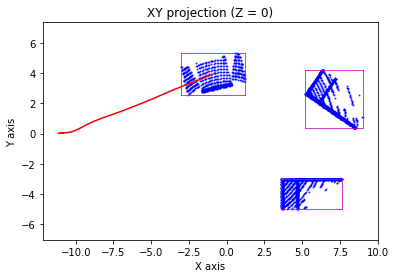

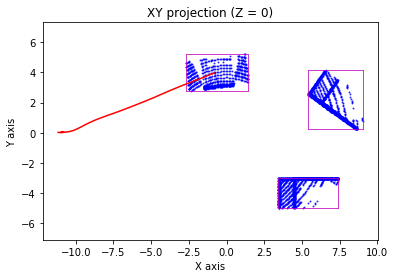

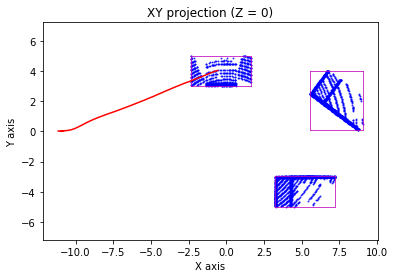

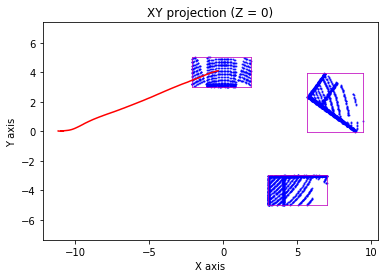

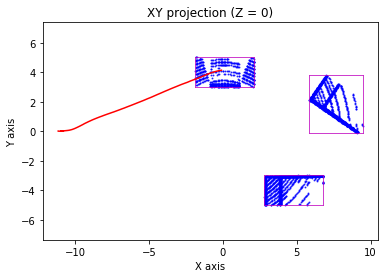

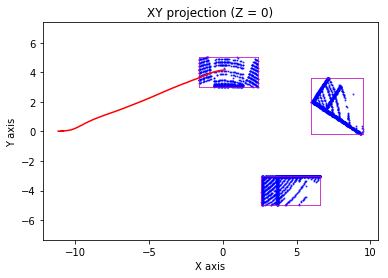

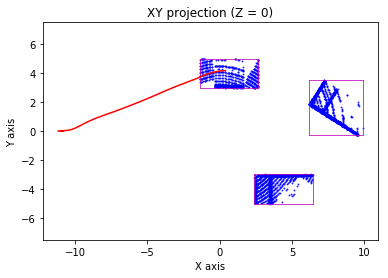

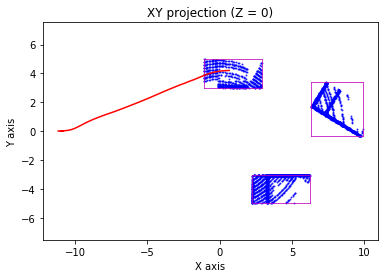

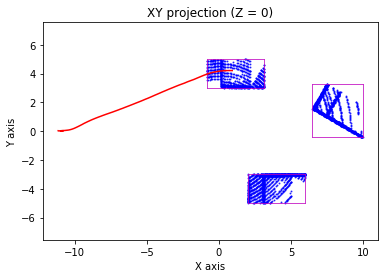

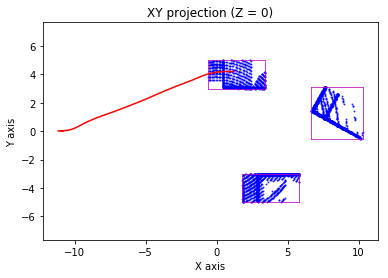

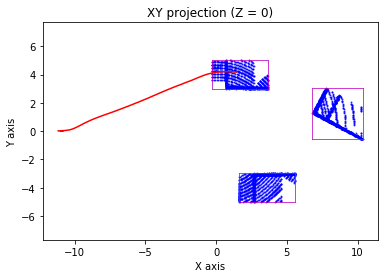

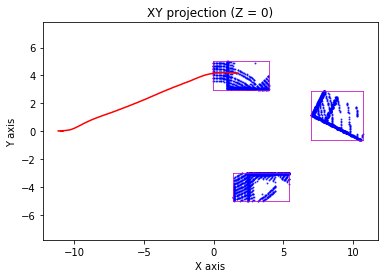

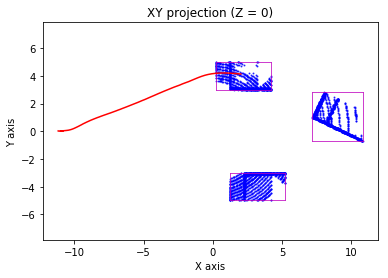

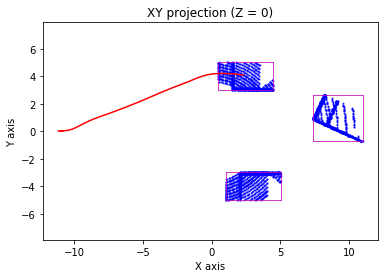

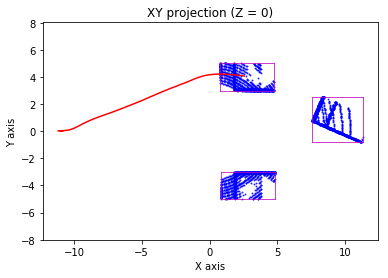

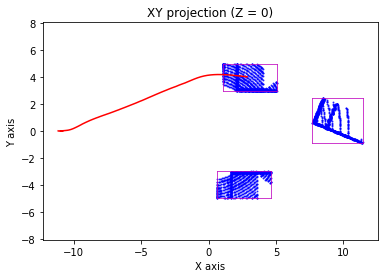

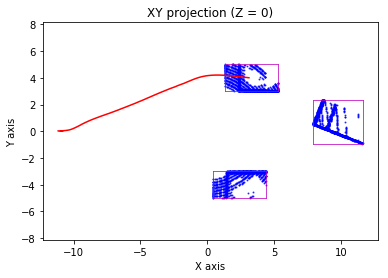

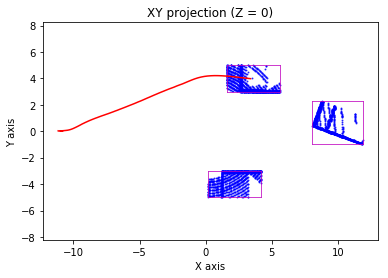

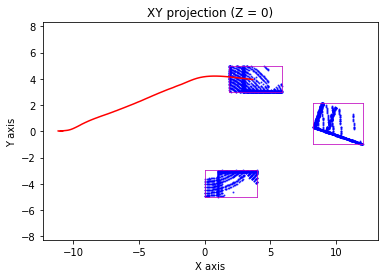

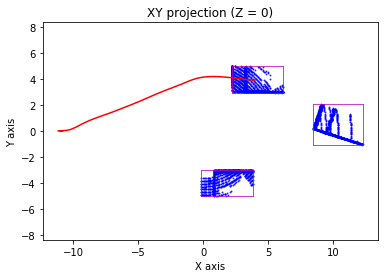

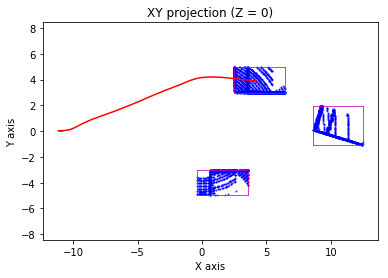

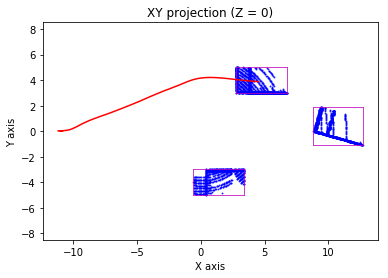

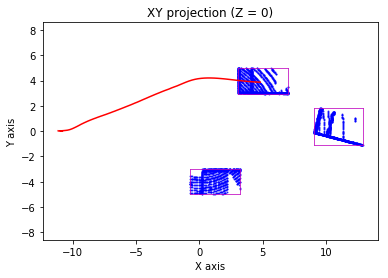

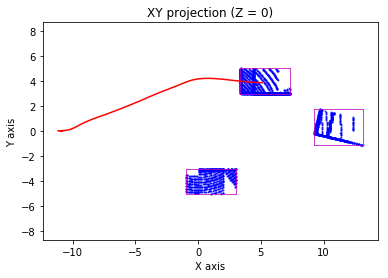

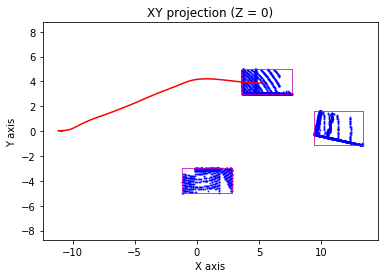

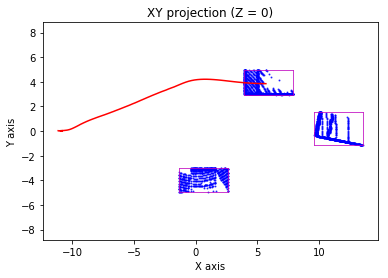

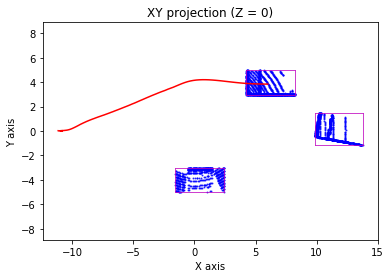

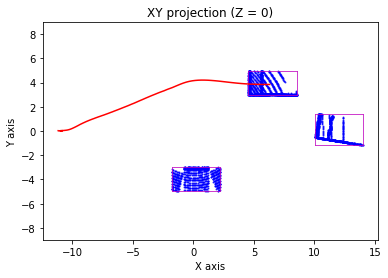

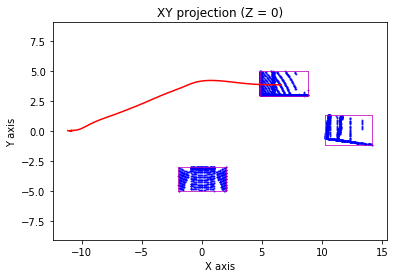

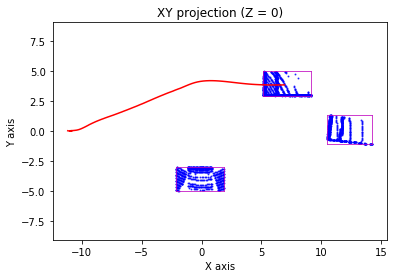

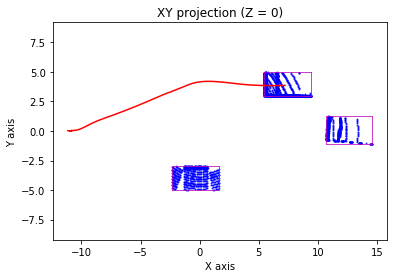

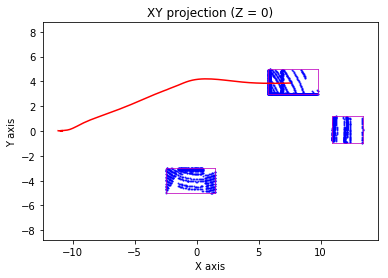

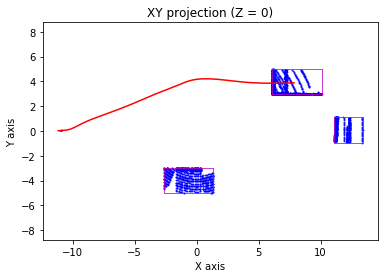

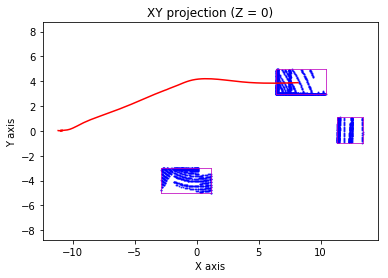

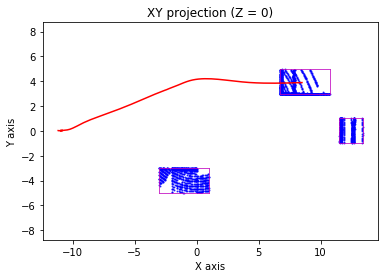

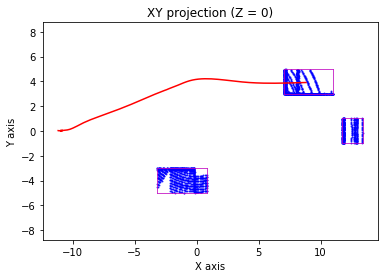

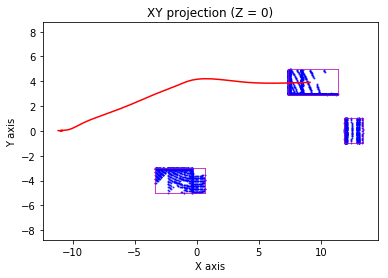

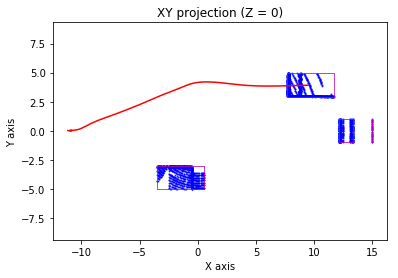

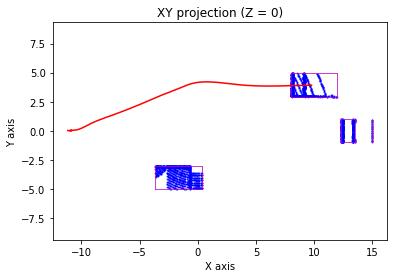

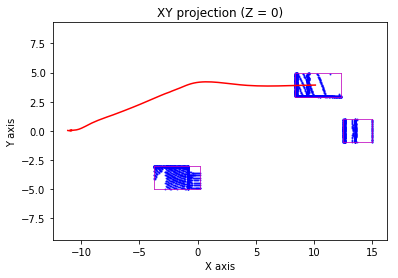

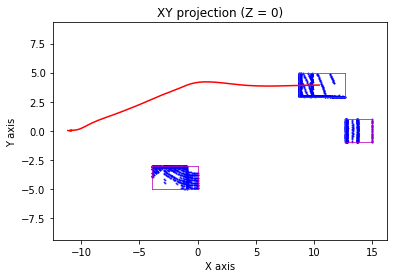

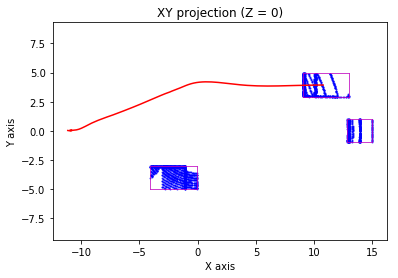

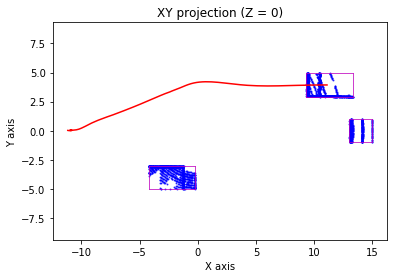

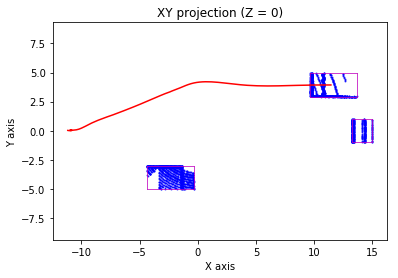

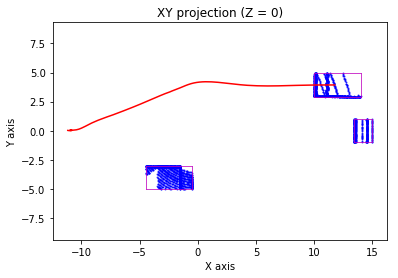

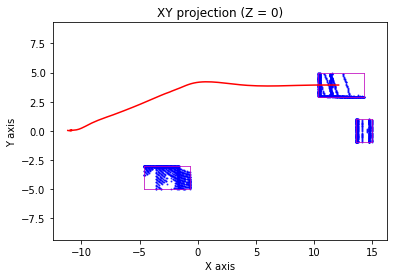

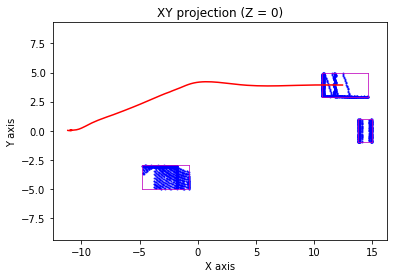

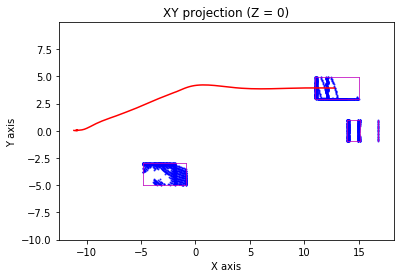

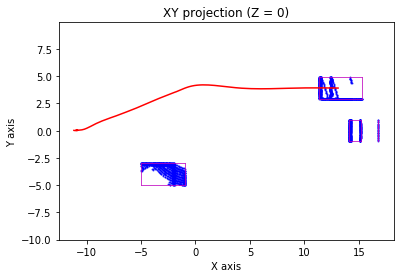

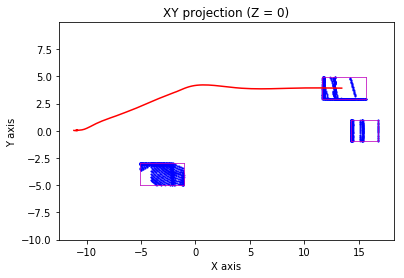

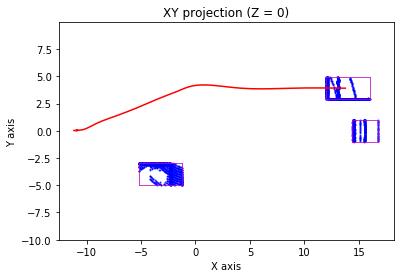

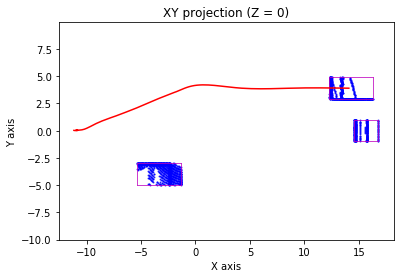

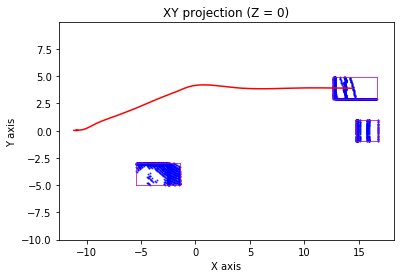

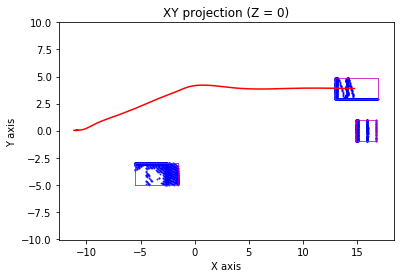

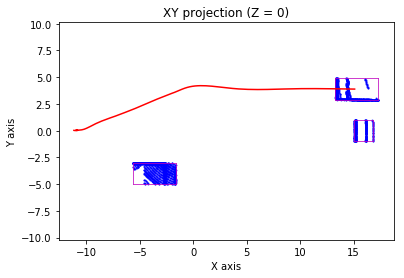

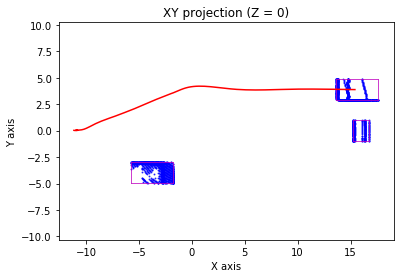

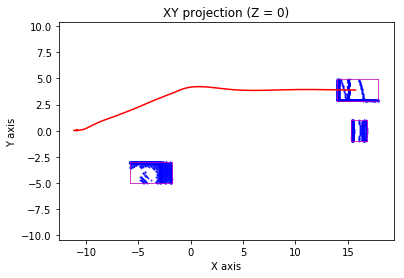

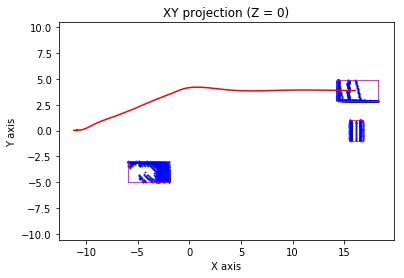

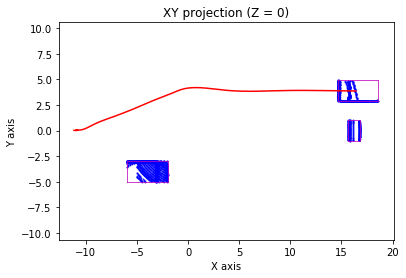

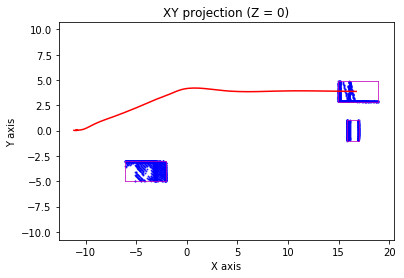

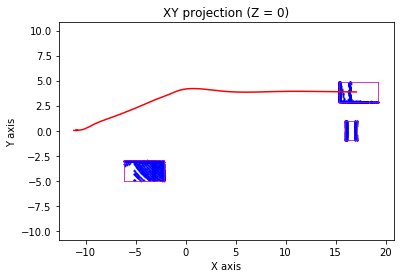

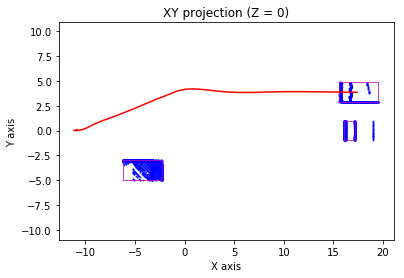

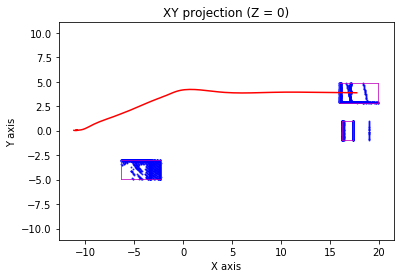

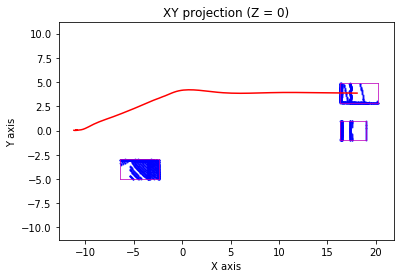

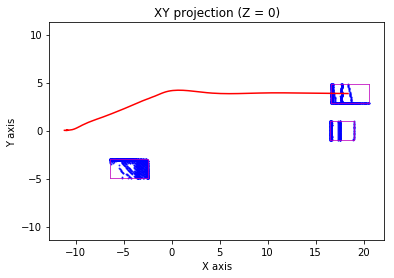

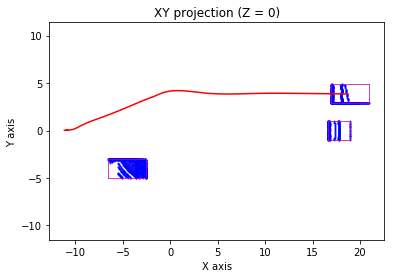

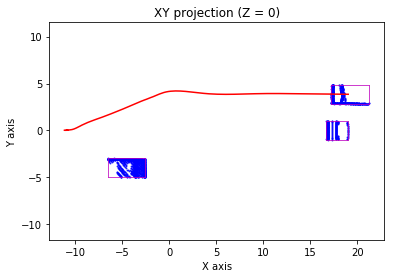

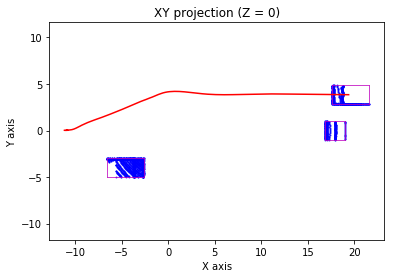

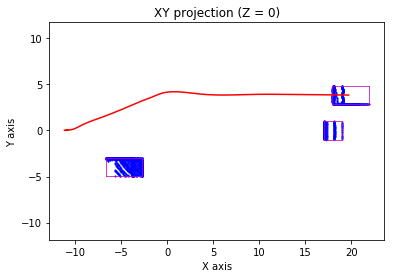

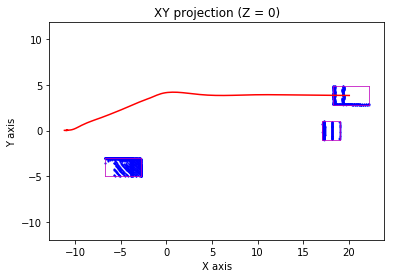

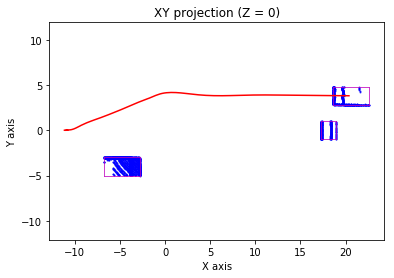

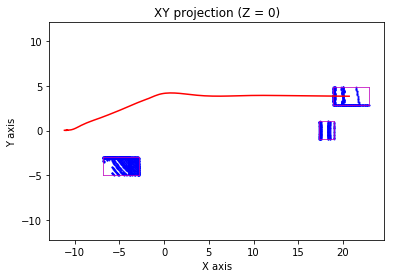

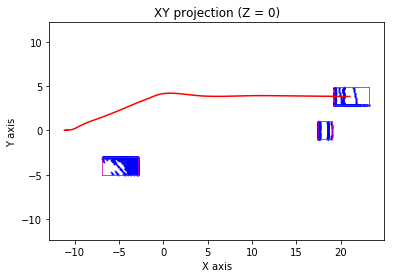

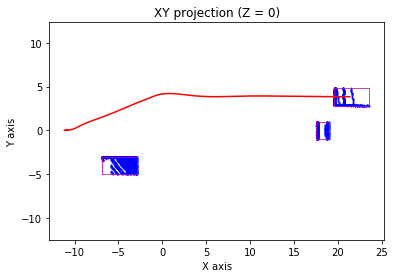

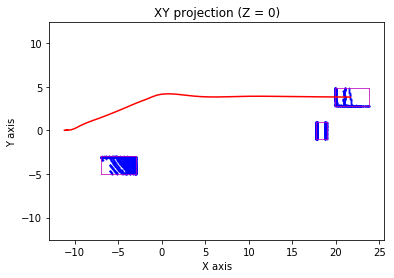

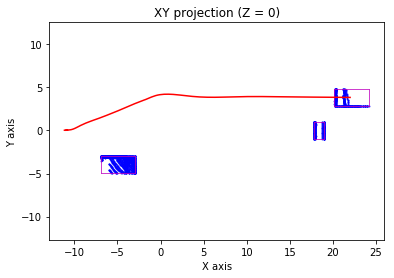

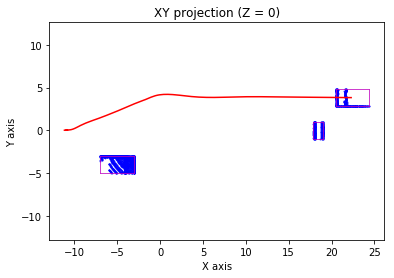

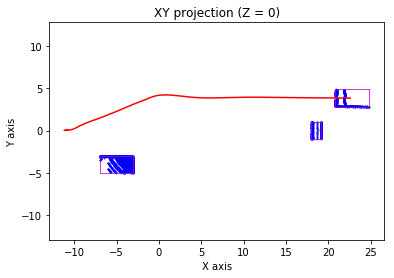

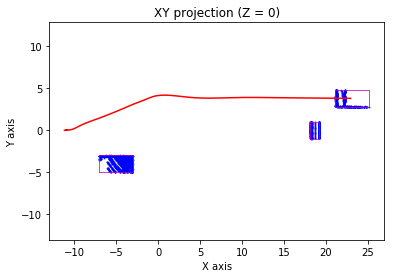

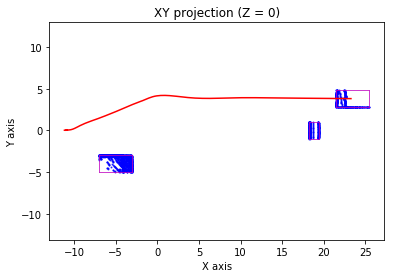

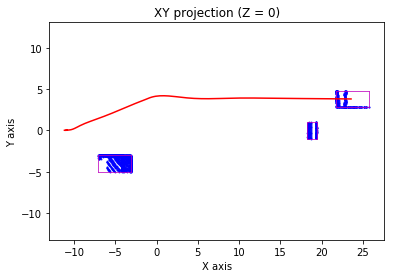

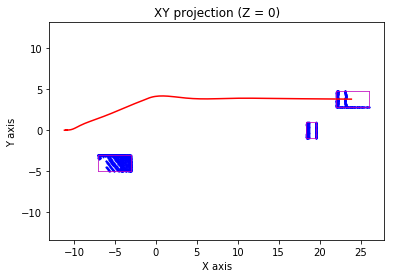

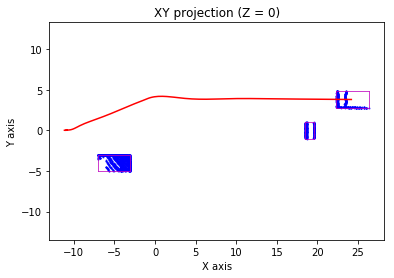

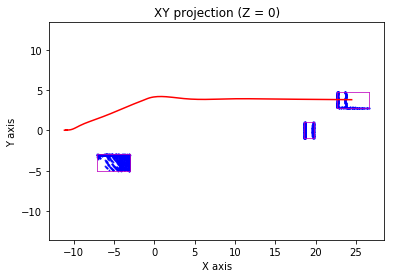

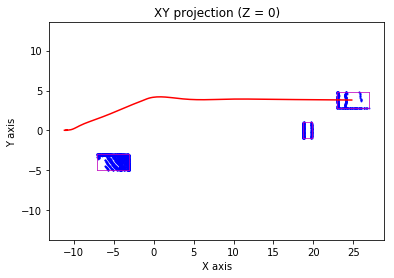

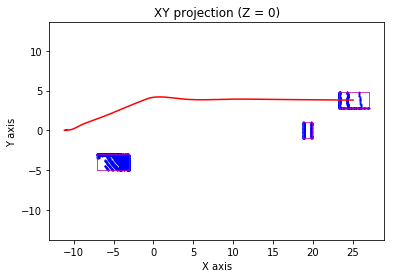

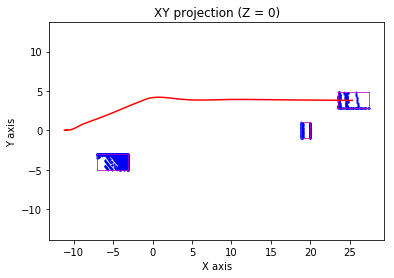

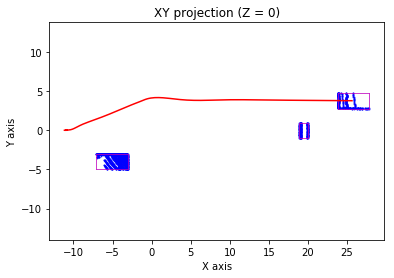

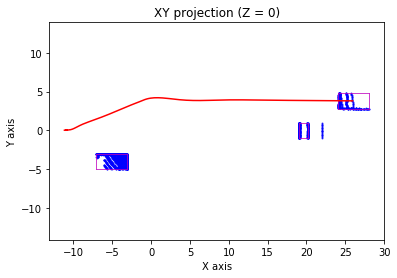

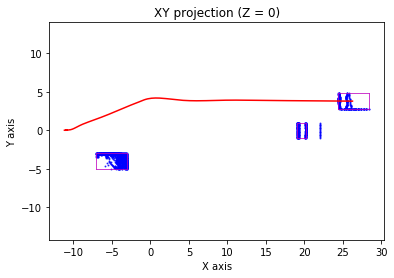

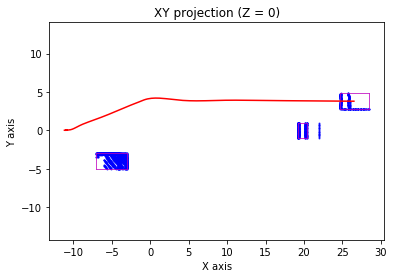

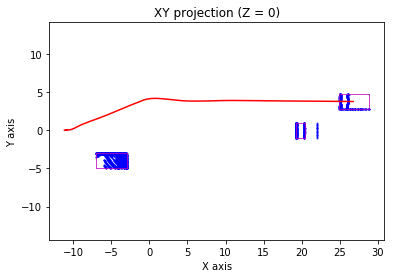

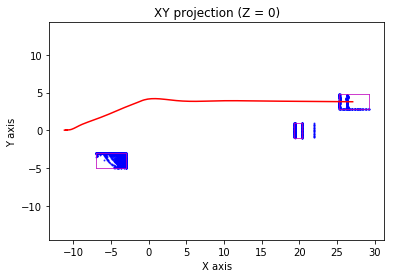

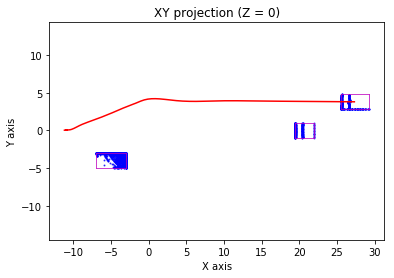

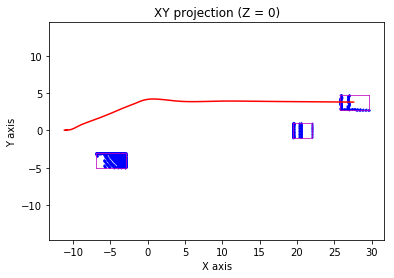

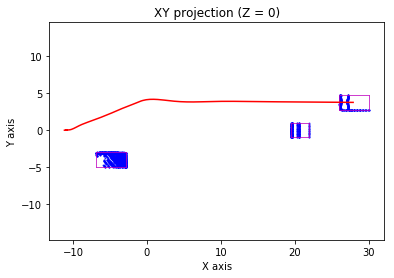

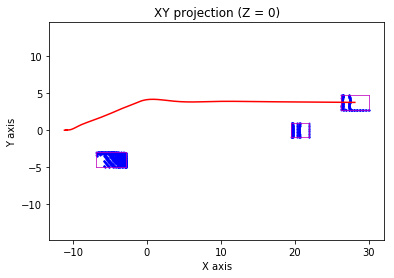

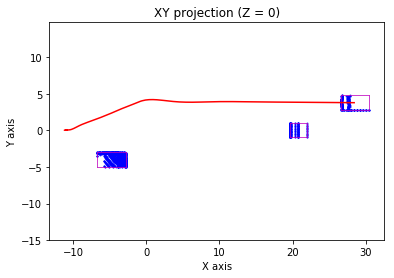

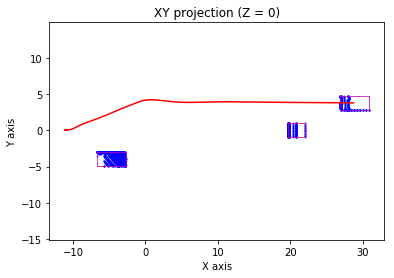

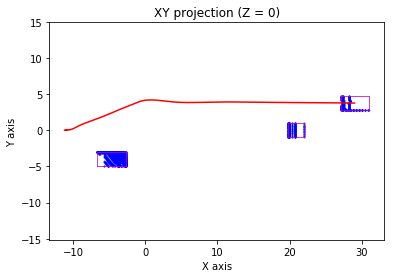

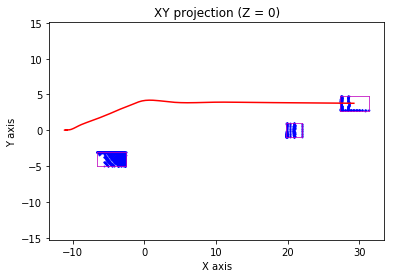

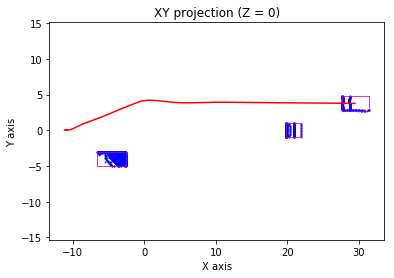

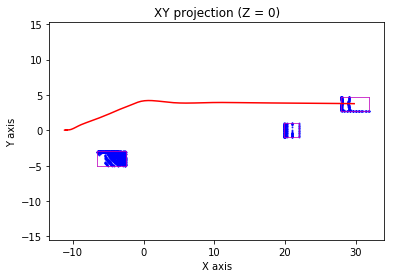

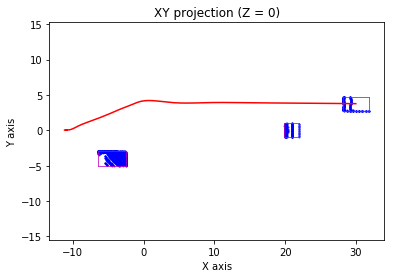

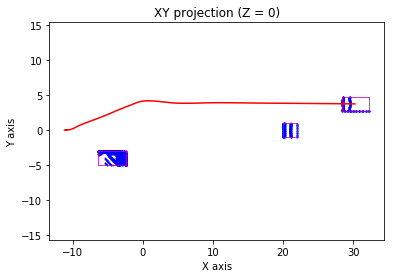

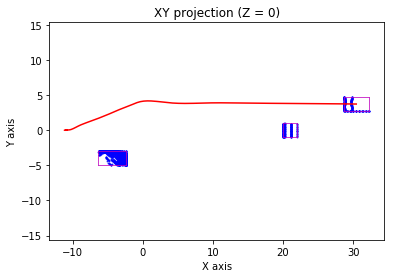

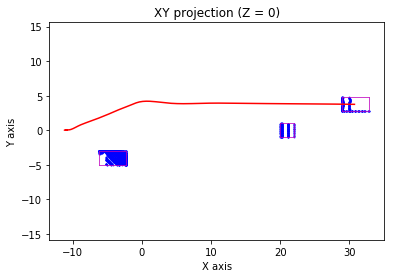

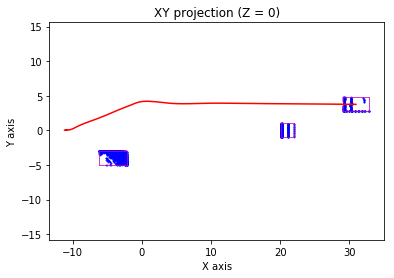

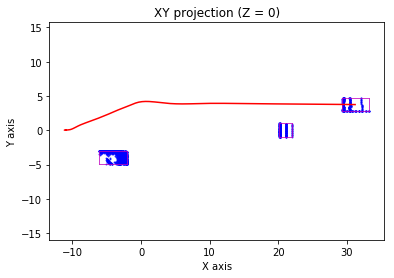

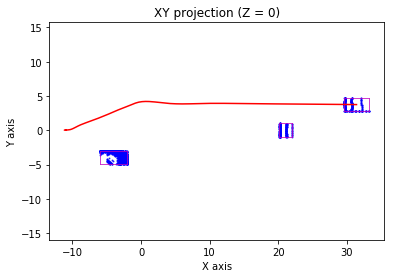

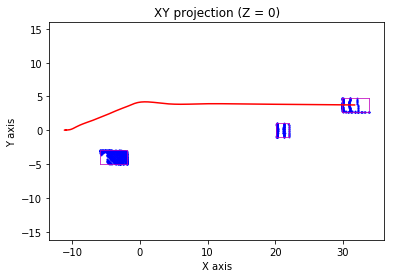

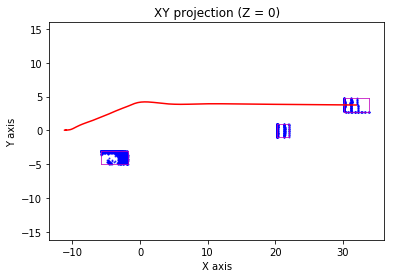

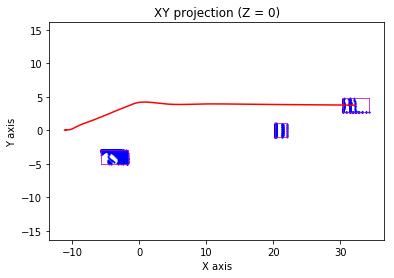

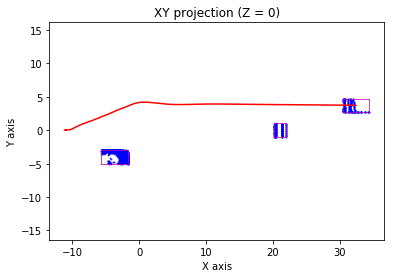

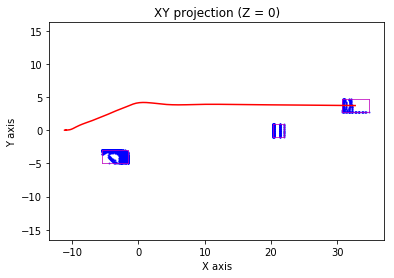

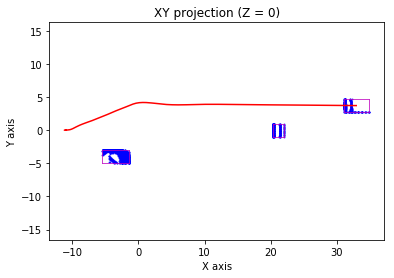

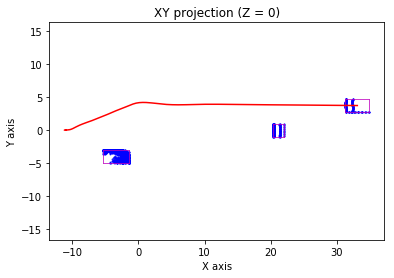

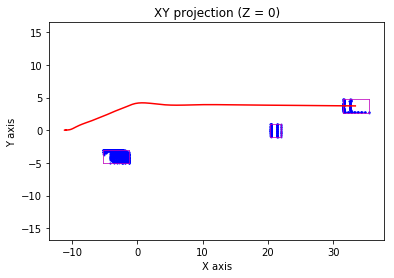

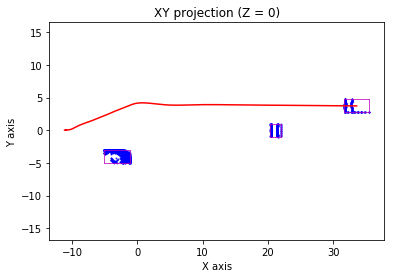

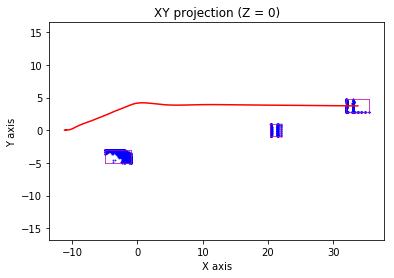

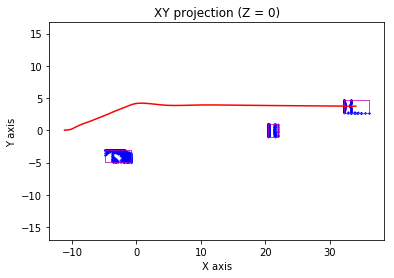

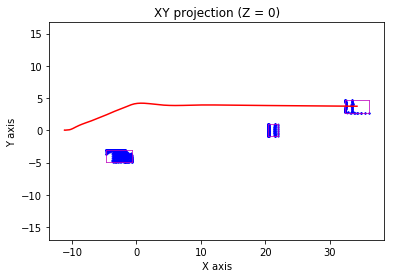

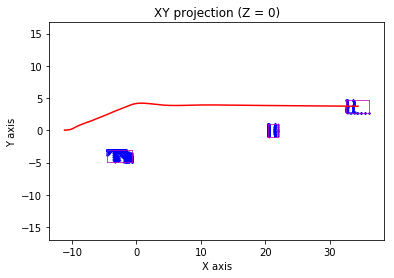

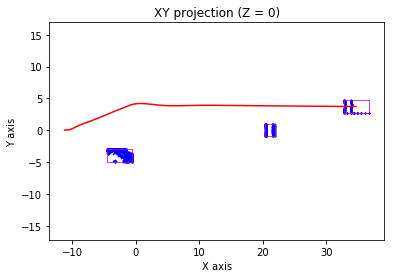

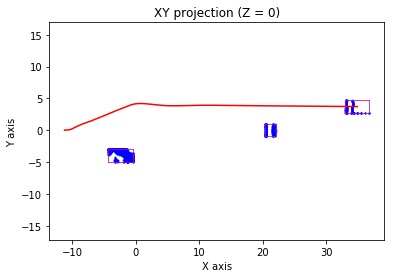

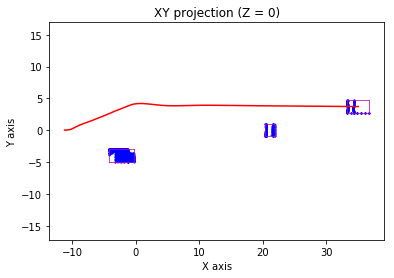

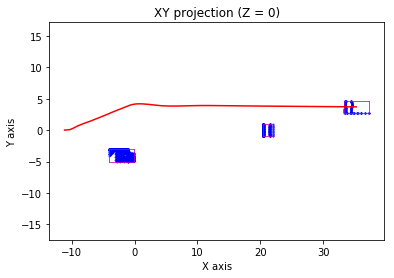

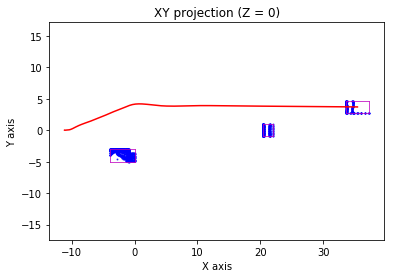

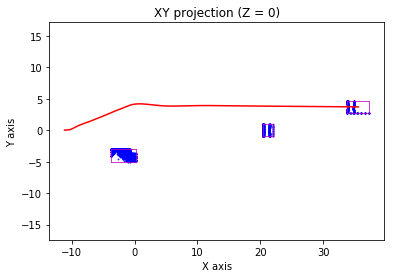

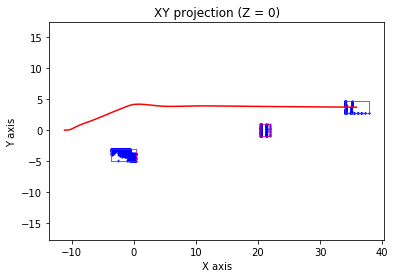

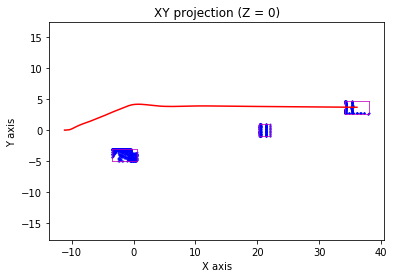

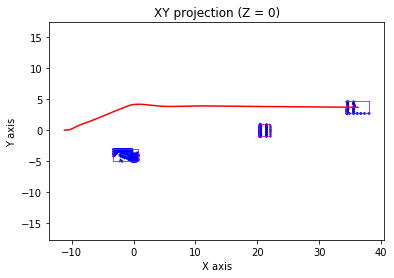

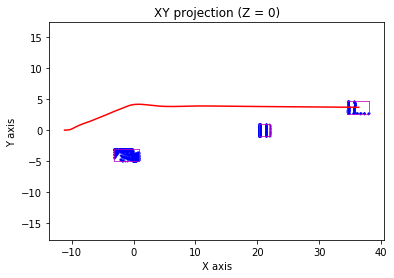

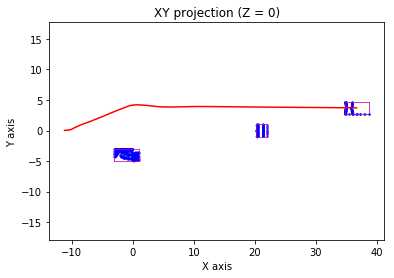

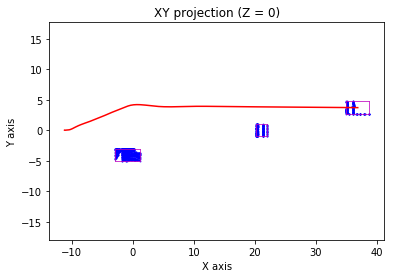

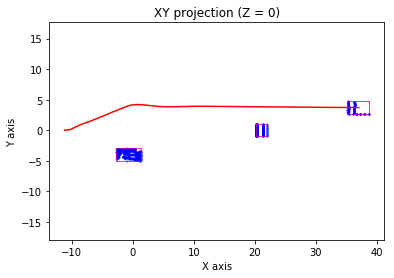

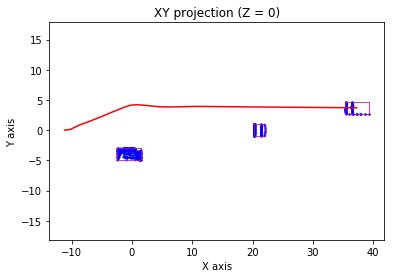

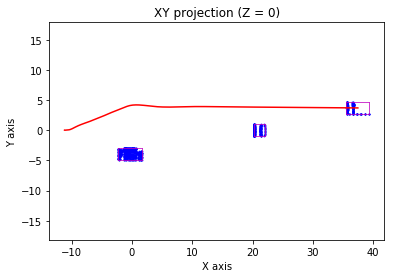

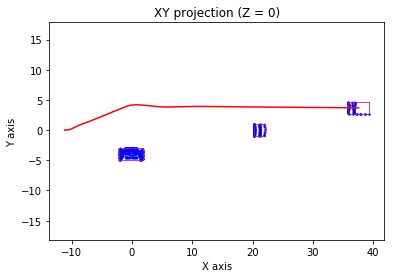

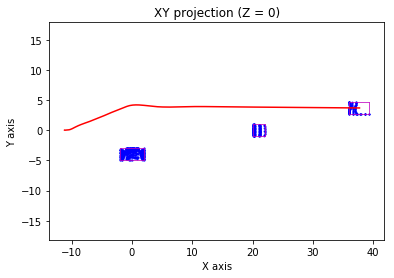

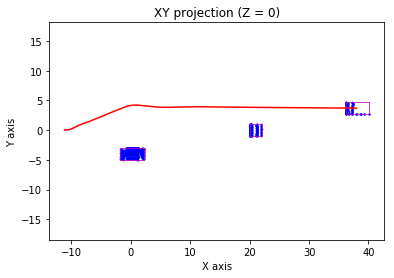

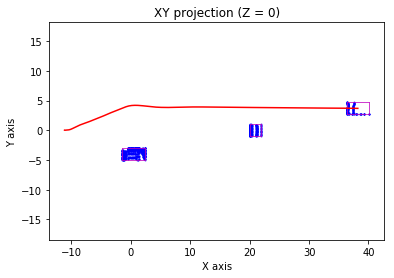

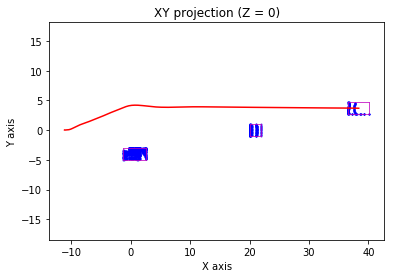

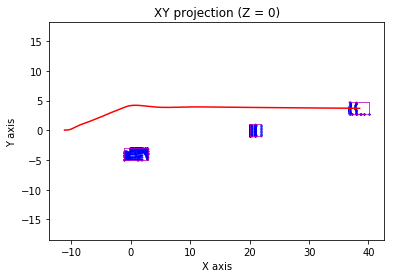

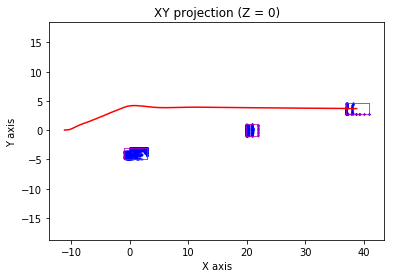

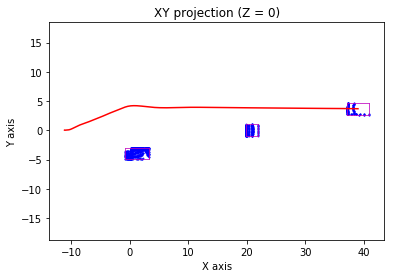

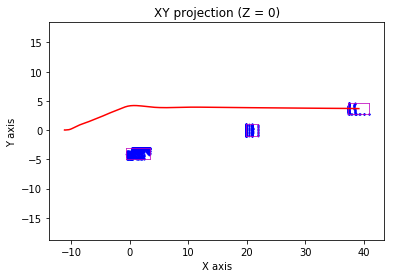

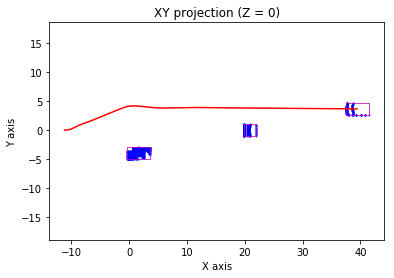

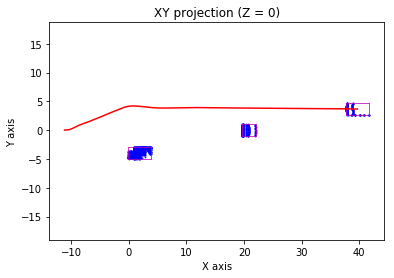

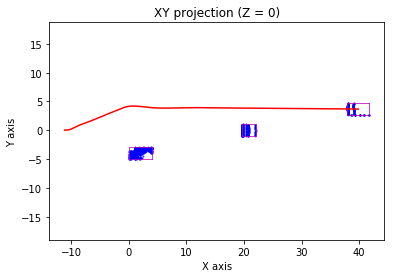

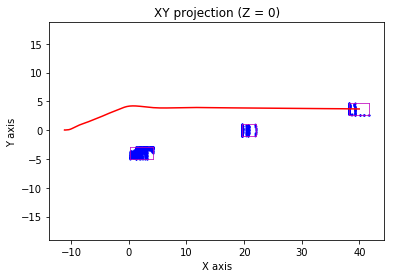

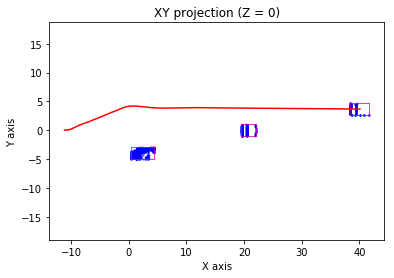

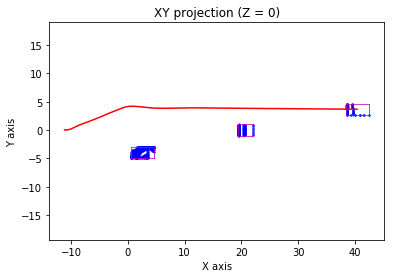

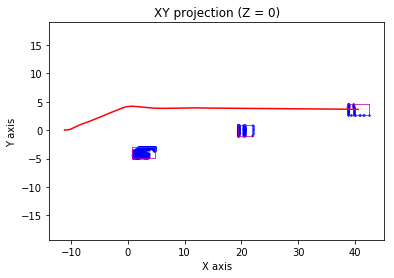

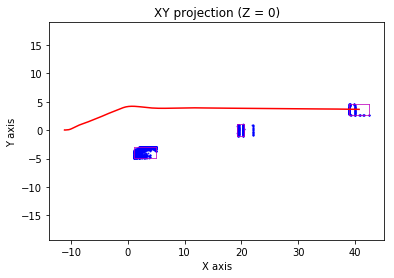

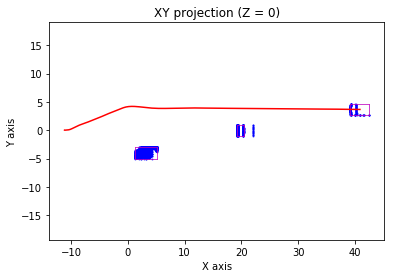

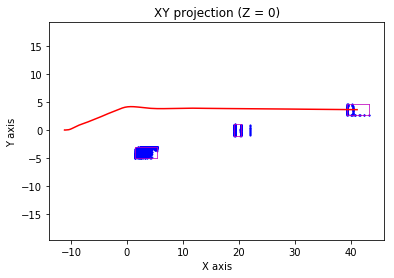

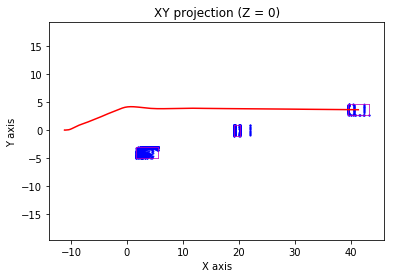

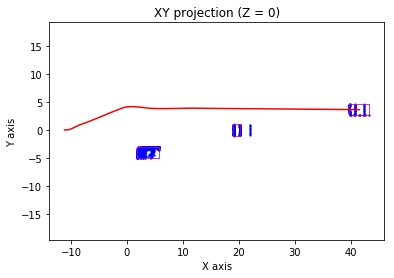

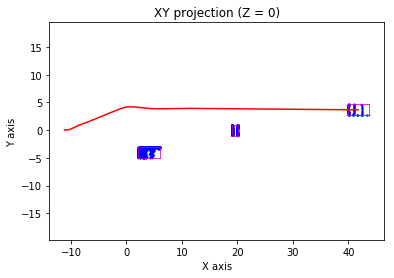

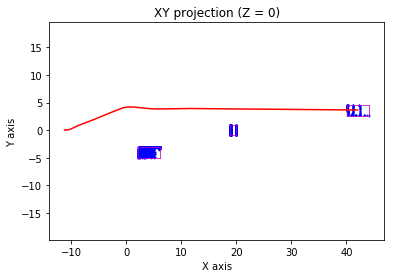

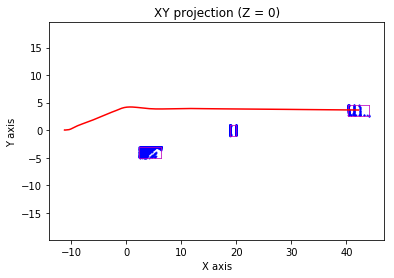

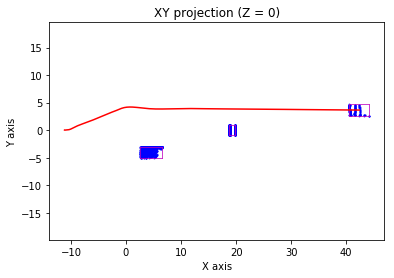

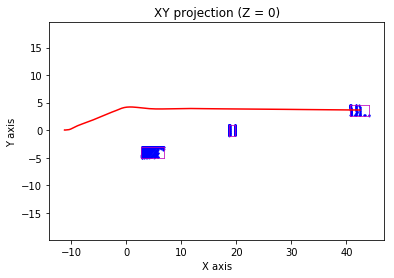

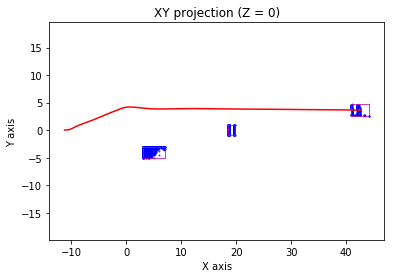

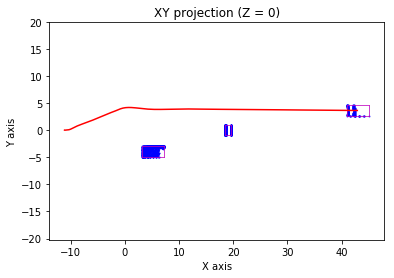

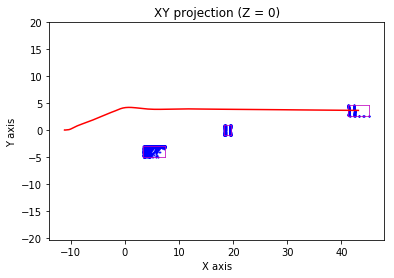

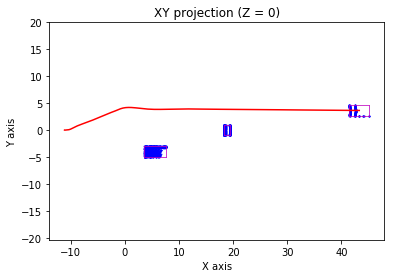

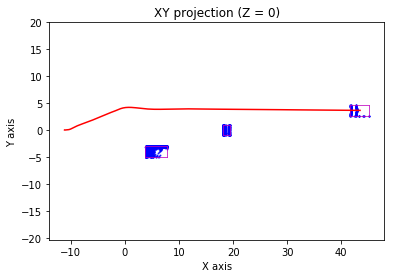

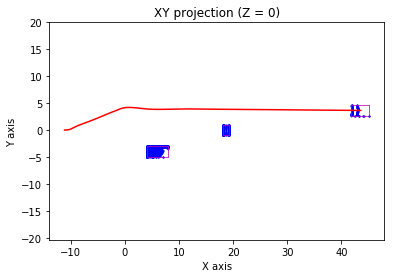

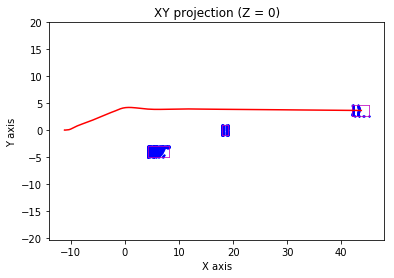

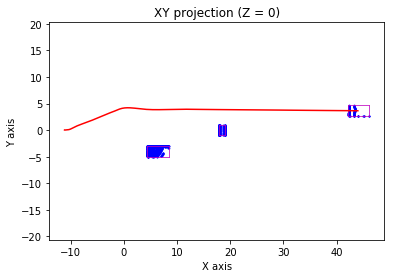

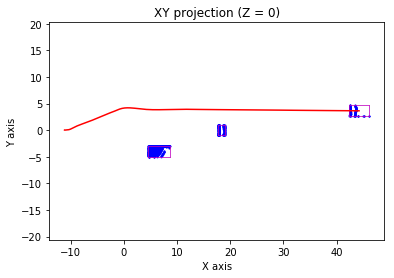

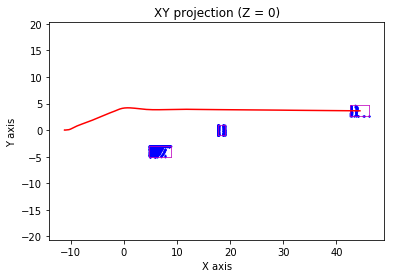

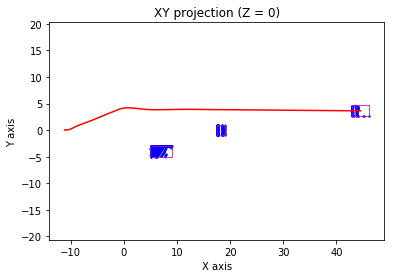

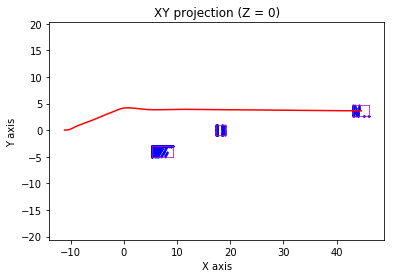

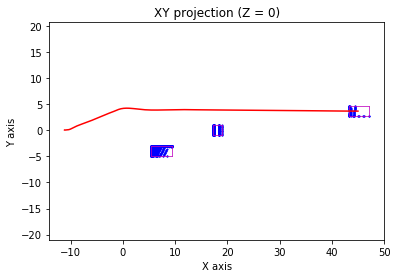

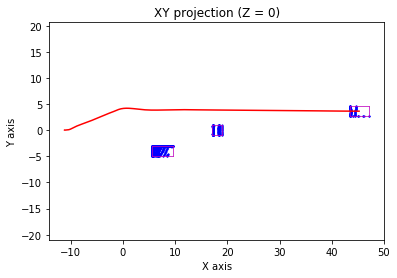

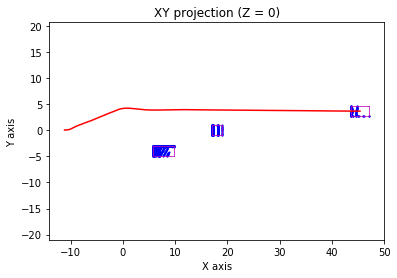

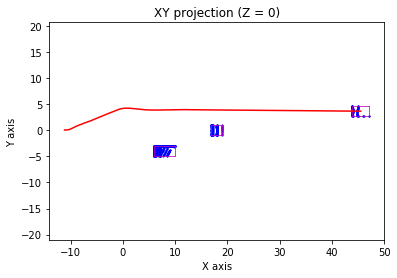

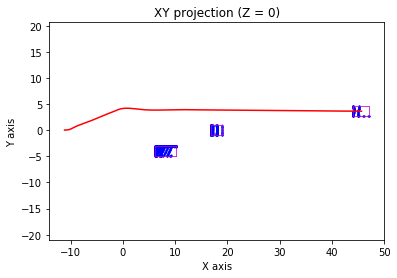

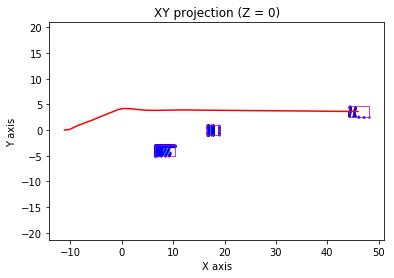

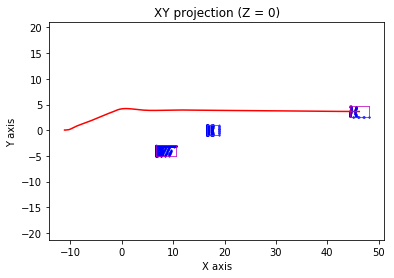

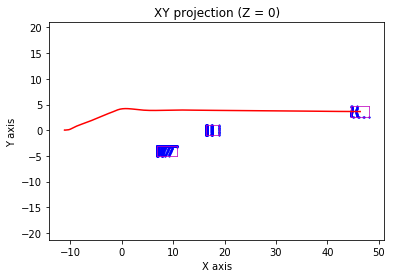

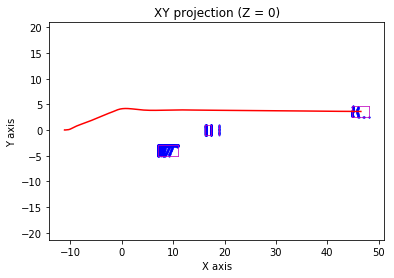

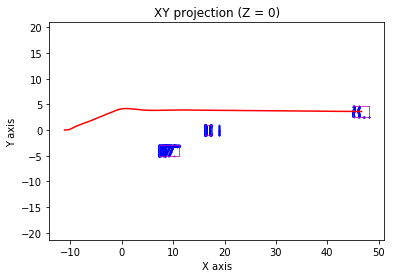

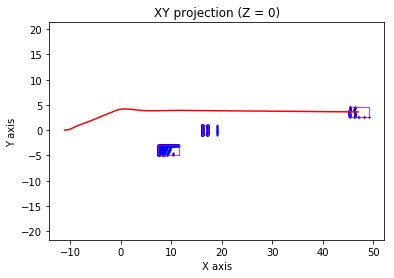

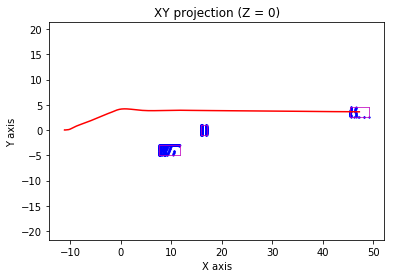

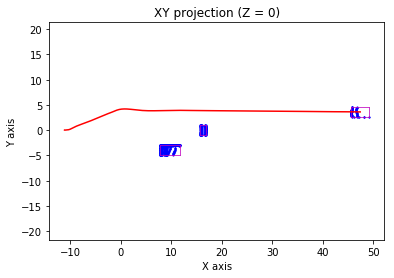

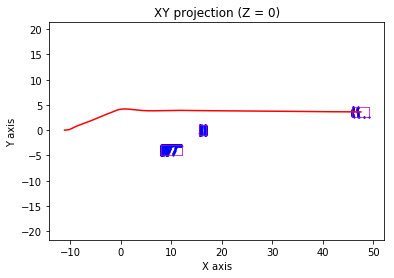

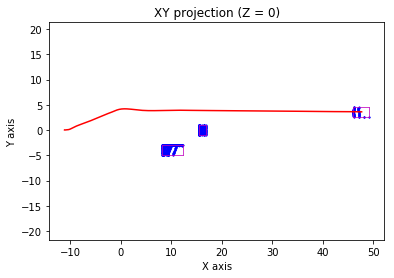

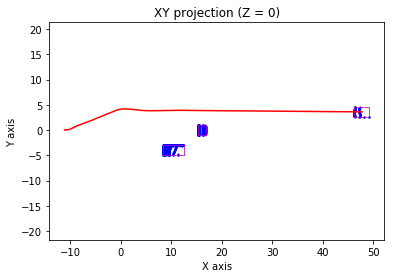

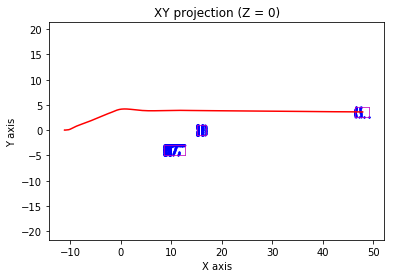

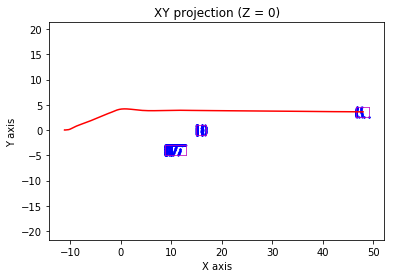

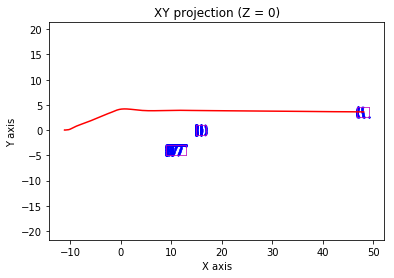

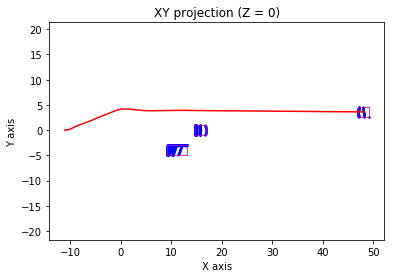

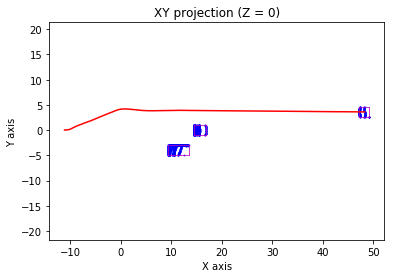

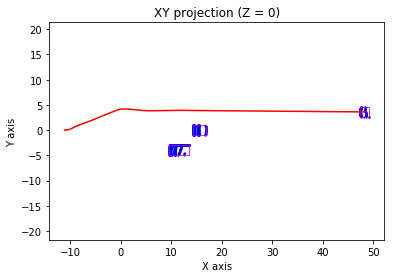

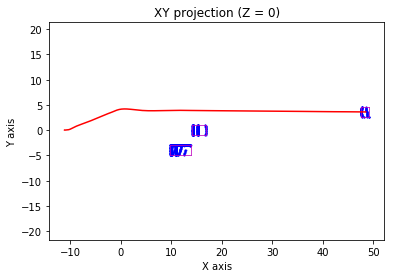

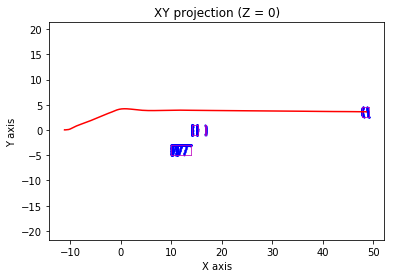

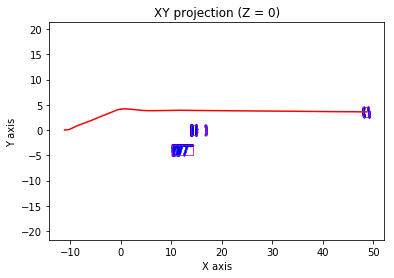

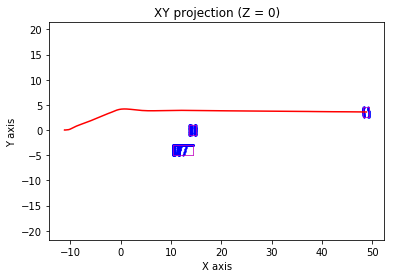

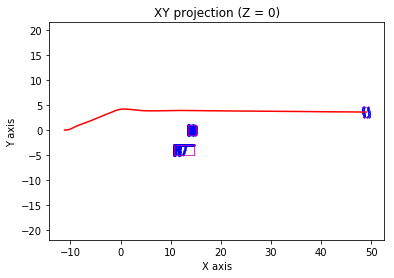

In [10]:
# Setup the UKF
dt = 0.033333
ukf = UKF(dim_x = 5, dim_z = 2, fx = ctrv, hx = lidar,
              dt = dt, alpha =.00001, beta = 2, kappa = 0, sigma_mode = 1,
              augmentation = True, dim_xa = 7, xa = np.array([0, 0]),
              x_resid = True, x_resid_indices = [3], z_resid = True, z_resid_indices = [1])
x0 = np.array([-10.5, 0.5, 0.8, 0, 0])
P0 = np.diag([2, 2, 5, 0.0255, 0.0255])
ukf.x = x0
ukf.P = P0
std_a = 150
std_yawdd = 0.8
estimate =[]
Qa = np.diag([std_a * std_a, std_yawdd * std_yawdd])
ukf.Qa = Qa
ukf.Q = np.zeros([5,5])
ukf.R = np.diag([0.15**2, 0.15**2])
lidar_lst = []

# Prepare point cloud file
pcd_files = glob('pcd/'+'*.pcd')

# Tracking with UKF
for idx, pcd_file in enumerate(pcd_files):
    ukf.prediction() 
    cloud_XYZI = pcl.load_XYZI(pcd_file)
    cloud_np = np.array(cloud_XYZI)
    cloud_XYZ = pcl.PointCloud()
    cloud_XYZ.from_array(cloud_np[:, 0:3])
    cloud_obsts, box_coord_list, xyz = lidar_pcl(cloud_XYZ, parameters)
    z_list = [x[0:2] for x in xyz]
    x = ukf.x[0:2]
    z0 = closest_measurement(x, z_list)
    lidar_lst.append(z0)
    ukf.update(z0)
    estimate.append([ukf.x_post[0], ukf.x_post[1],ukf.x_post[2]*cos(ukf.x_post[3]), ukf.x_post[2]*sin(ukf.x_post[3])])
    tracking_visualization(cloud_obsts, box_coord_list, axes_str=['X', 'Y', 'Z'], axes_limits = [[-10, 50], [-2, 6], [-2, 5] ])
estimate_np = np.array(estimate) 
lidar_np = np.array(lidar_lst)